# Оптимизация управления персоналом компании 

HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников. В этом HR-аналитикам пригодится машинное обучение, с помощью которого получится быстрее и точнее отвечать на вопросы бизнеса.
Компания предоставила данные с характеристиками сотрудников компании. 

**Цель:** Спрогнозировать отток сотрудников.

**Задачи:** 

    1. Построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. 
    2. Построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.
    
**Описание данных:**
Заказчик предоставил данные с признаками:

- `id` — уникальный идентификатор сотрудника;
- `dept` — отдел, в котором работает сотрудник;
- `level` — уровень занимаемой должности;
- `workload` — уровень загруженности сотрудника;
- `employment_years` — длительность работы в компании (в годах);
- `last_year_promo` — показывает, было ли повышение за последний год;
- `last_year_violations` — показывает, нарушал ли сотрудник трудовой договор за последний год;
- `supervisor_evaluation` — оценка качества работы сотрудника, которую дал руководитель;
- `salary` — ежемесячная зарплата сотрудника;
- `job_satisfaction_rate` — уровень удовлетворённости сотрудника работой в компании, целевой признак.
- `quit` - увольнение сотрудника из компании (используется во второй задаче)

**План:**
1. Задача 1
    1. Загрузка данных
    2. Предобработка данных
    3. Исследовательский анализ данных
    4. Подготовка данных
    5. Обучение моделей
    6. Вывод
2. Задача 2
    1. Загрузка данных
    2. Предобработка данных
    3. Исследовательский анализ данных
    4. Добавление нового входного признака
    5. Подготовка данных
    6. Обучение моделей
    7. Вывод
3. Общий вывод

In [1]:
!pip install phik -q
!pip install shap==0.44.0  -q
!pip install scikit-learn==1.3.2 -q

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import phik
import shap
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.metrics import make_scorer
from sklearn.preprocessing import (OneHotEncoder,
                                   OrdinalEncoder,
                                   StandardScaler,
                                   LabelEncoder)
from sklearn.impute import SimpleImputer   
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.linear_model import LinearRegression 
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score

RANDOM_STATE = 42

## Задача 1 

### Загрузка данных

In [3]:
Xy_train1 = pd.read_csv('C:/FATHER/datasets/train_job_satisfaction_rate.csv')
X_test1 = pd.read_csv('C:/FATHER/datasets/test_features.csv')
y_test1 = pd.read_csv('C:/FATHER/datasets/test_target_job_satisfaction_rate.csv')

In [4]:
def description(df):
    display(df.head())
    df.info()

In [5]:
description(Xy_train1)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


In [6]:
description(X_test1)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


Данные в датасете не упорядоченны, отсортируем из по столбцу `id`.

In [7]:
X_test1 = X_test1.sort_values('id')
X_test1.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
1172,100298,hr,junior,low,2,no,no,4,19200
852,100480,marketing,junior,low,4,no,no,4,16800
848,100503,purchasing,middle,high,5,no,no,4,55200
524,100610,sales,middle,medium,5,no,no,4,43200
476,100692,sales,middle,high,6,no,no,4,48000


In [8]:
description(y_test1)

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


Так же как и `X_test1` отсортируем данные по столбцу `id`.

In [9]:
y_test1 = y_test1.sort_values('id')
y_test1.head()

,id,job_satisfaction_rate
1734,100298,0.80
1467,100480,0.84
190,100503,0.79
60,100610,0.75
231,100692,0.69


**Вывод:** Данные соответствуют описанию. Все признаки верных типов данных. Присутствует несколько пропусков.

### Предобработка данных

#### Xy_train1
Проверим значения признаков датасета `Xy_train1` на наличие "разночтений".

In [10]:
col = ['dept','level','workload','last_year_promo','last_year_violations']

In [11]:
def uniq(df, col):
    for c in col:
        print(c, df[c].unique())

In [12]:
uniq(Xy_train1,col)

dept ['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]
level ['junior' 'middle' 'sinior' nan]
workload ['medium' 'high' 'low']
last_year_promo ['no' 'yes']
last_year_violations ['no' 'yes']


Исправим ошибку в "sinior".

In [13]:
Xy_train1['level'] = Xy_train1['level'].replace('sinior','senior')

"Разночтений" нет. Проверим не встречаются ли сотрудники дважды в данных и заменим индексы на значения `id`.

In [14]:
Xy_train1.duplicated('id').sum()

0

Заменим индексы на значения `id`.

In [15]:
Xy_train1 = Xy_train1.set_index('id')
Xy_train1.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
155278,sales,junior,medium,2,no,no,1,24000,0.58
653870,hr,junior,high,2,no,no,5,38400,0.76
184592,sales,junior,low,1,no,no,2,12000,0.11
171431,technology,junior,low,4,no,no,2,18000,0.37
693419,hr,junior,medium,1,no,no,3,22800,0.20


In [16]:
Xy_train1.duplicated().sum()

245

In [17]:
Xy_train1 = Xy_train1.drop_duplicates()

In [18]:
Xy_train1.duplicated().sum()

0

В данных есть дубликаты. Мы их удалили, так как эти данные не принесут пользы моделе.

#### X_test1
Сделаем то же самое для датасета `X_test1`.

In [19]:
uniq(X_test1,col)

dept ['hr' 'marketing' 'purchasing' 'sales' 'technology' nan ' ']
level ['junior' 'middle' 'sinior' nan]
workload ['low' 'high' 'medium' ' ']
last_year_promo ['no' 'yes']
last_year_violations ['no' 'yes']


In [20]:
X_test1['level'] = X_test1['level'].replace('sinior','senior')

В признаках `dept` и `workload` содержится значение ' '. Заменим его на пропуск в пайплайне в следующих шагах.

In [21]:
X_test1.duplicated('id').sum()

0

In [22]:
X_test1 = X_test1.set_index('id')
X_test1.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
id,,,,,,,,
100298,hr,junior,low,2,no,no,4,19200
100480,marketing,junior,low,4,no,no,4,16800
100503,purchasing,middle,high,5,no,no,4,55200
100610,sales,middle,medium,5,no,no,4,43200
100692,sales,middle,high,6,no,no,4,48000


#### y_test1
Проверим дубликаты и заменим индексы в `y_test1`.

In [23]:
y_test1.duplicated('id').sum()

0

In [24]:
y_test1 = y_test1.set_index('id')
y_test1.head()

,job_satisfaction_rate
id,
100298,0.80
100480,0.84
100503,0.79
100610,0.75
100692,0.69


**Вывод:** В данных нет "разночтений", дубликаты удалены. Пропущенные значения в `X_test1` мы заменили на пропуски. Пропуски в данных будем обрабатывать в пайплайне в следующих шагах.

### Исследовательский анализ данных

#### Dept

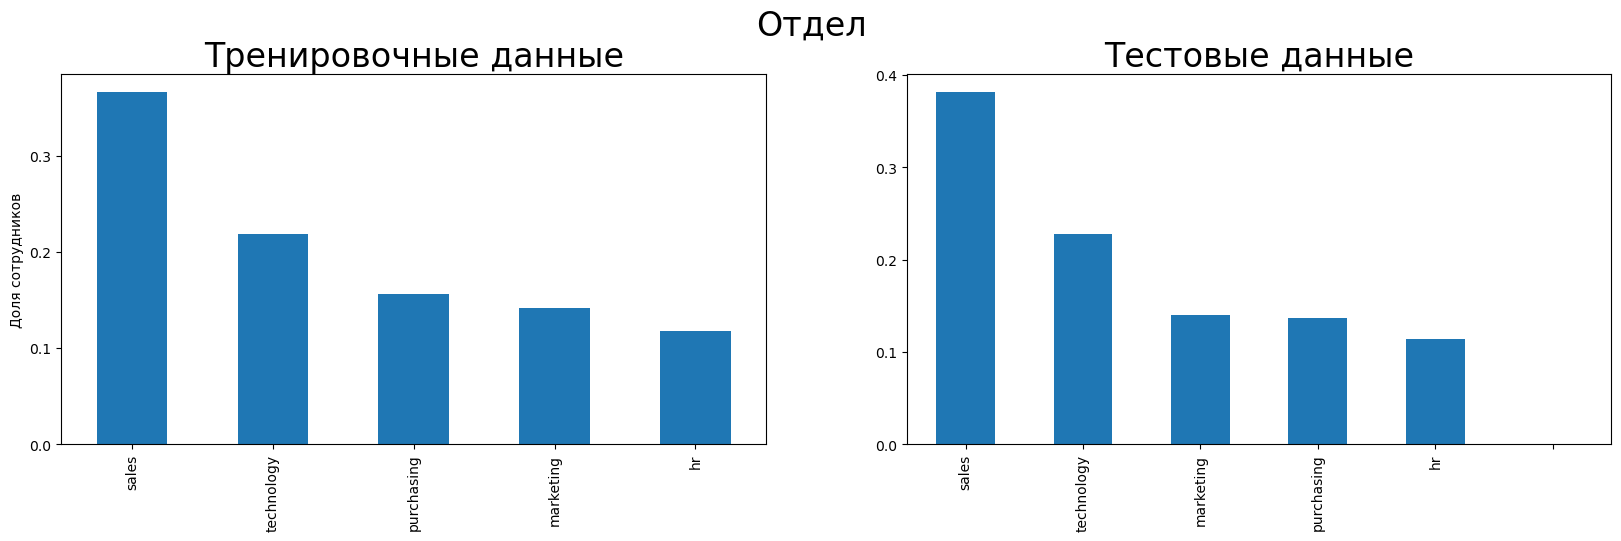

In [25]:
fig, axs = plt.subplots(nrows= 1 , ncols= 2 )
fig.set_size_inches(20, 5)
plt.rcParams['font.size'] = '20'

Xy_train1['dept'].value_counts(normalize=True).plot(kind='bar',ax=axs[0])
axs[0].set_title('Тренировочные данные')
axs[0].set_ylabel('Доля сотрудников')

X_test1['dept'].value_counts(normalize=True).plot(kind='bar',ax=axs[1])
axs[1].set_title('Тестовые данные')

fig.suptitle('Отдел')
plt.subplots_adjust(top= 0.85)
plt.show()

Соотношение сотрудников по отделам в тренировочных и тестовых данных одинаковое. Больше всего сотрудников в отделе продаж.

#### Level

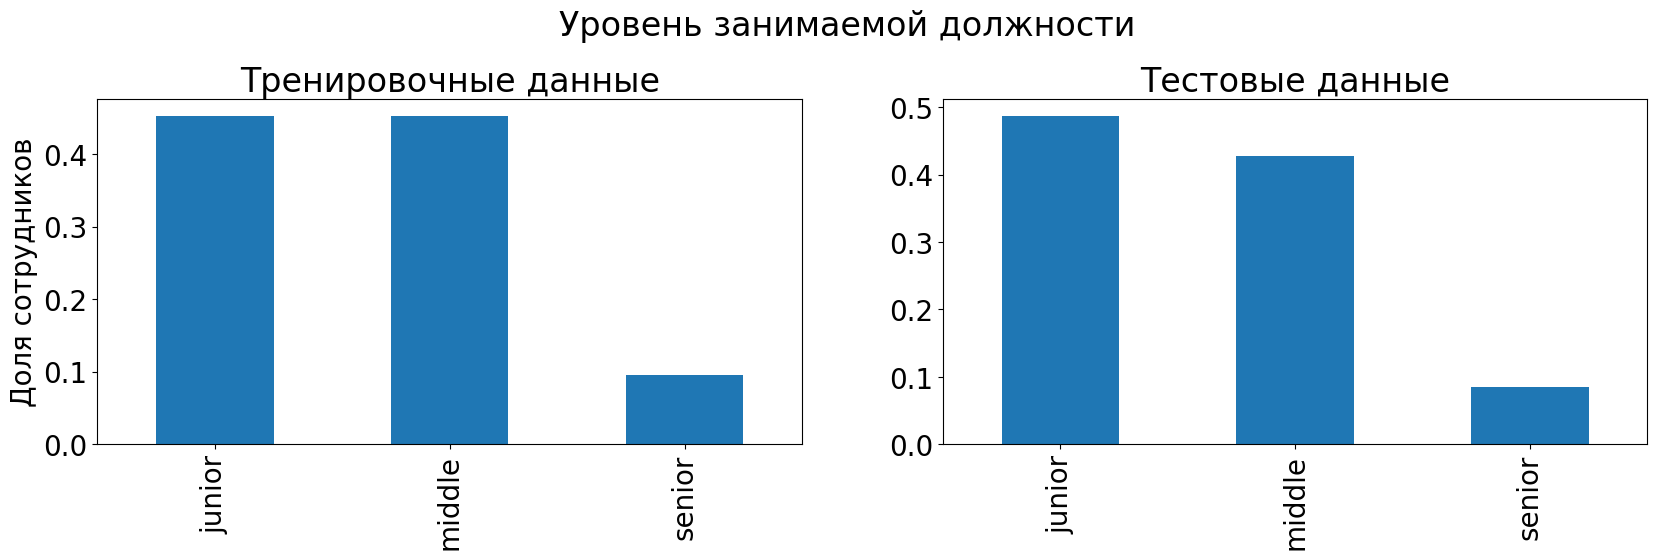

In [26]:
fig, axs = plt.subplots(nrows= 1 , ncols= 2 )
fig.set_size_inches(20, 5)
plt.rcParams['font.size'] = '20'

Xy_train1['level'].value_counts(normalize=True).plot(kind='bar',ax=axs[0])
axs[0].set_title('Тренировочные данные')
axs[0].set_ylabel('Доля сотрудников')

X_test1['level'].value_counts(normalize=True).plot(kind='bar',ax=axs[1])
axs[1].set_title('Тестовые данные')

fig.suptitle('Уровень занимаемой должности')
plt.subplots_adjust(top= 0.8)
plt.show()

Больше всего в компании джуниор сотрудников и незначительно меньше мидл сотрудников.

#### Workload	

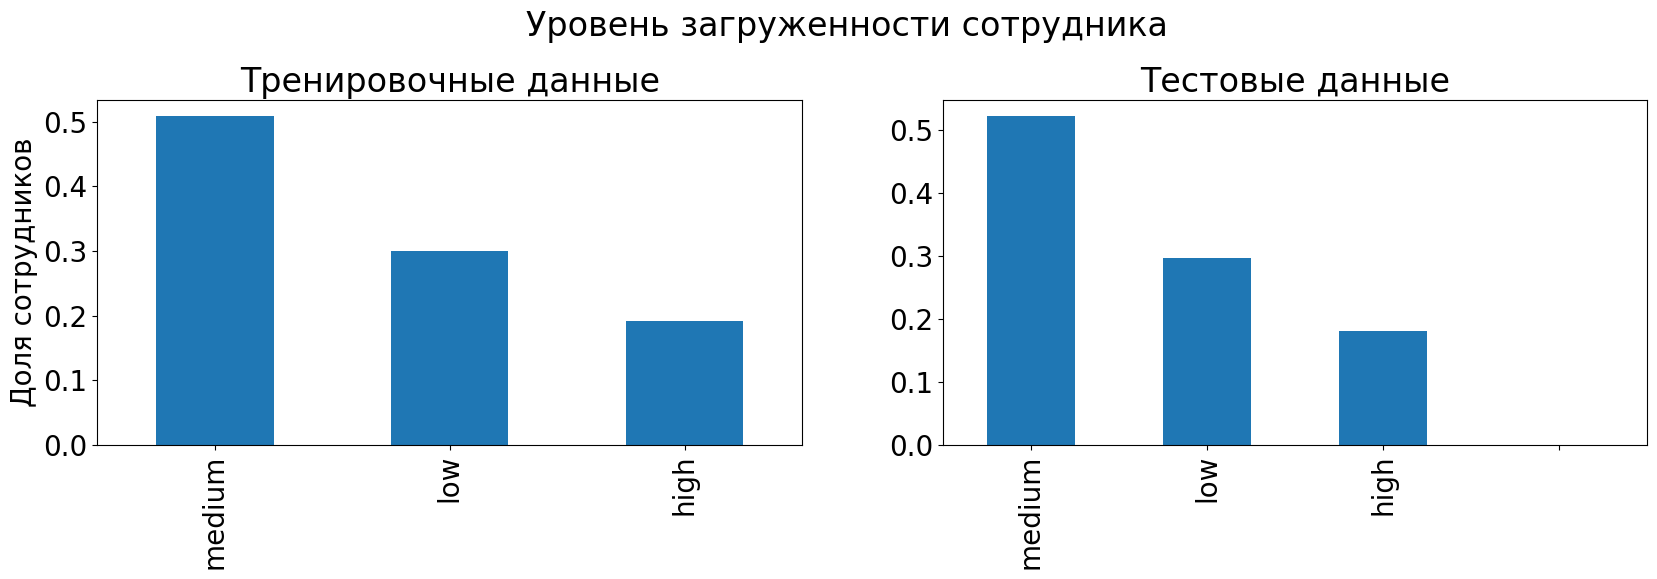

In [27]:
fig, axs = plt.subplots(nrows= 1 , ncols= 2 )
fig.set_size_inches(20, 5)
plt.rcParams['font.size'] = '20'

Xy_train1['workload'].value_counts(normalize=True).plot(kind='bar',ax=axs[0])
axs[0].set_title('Тренировочные данные')
axs[0].set_ylabel('Доля сотрудников')

X_test1['workload'].value_counts(normalize=True).plot(kind='bar',ax=axs[1])
axs[1].set_title('Тестовые данные')

fig.suptitle('Уровень загруженности сотрудника')
plt.subplots_adjust(top= 0.8)
plt.show()

В основном у сотрудников средний уровень загруженности.

#### Employment_years

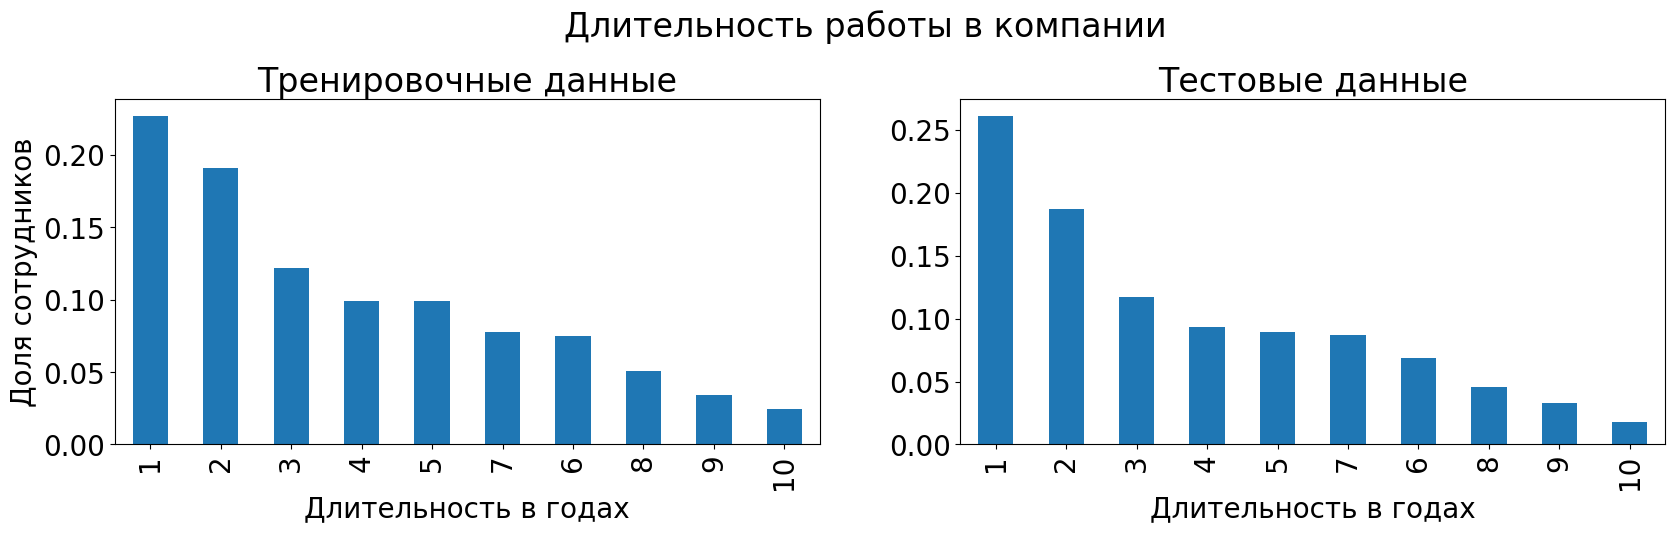

In [28]:
fig, axs = plt.subplots(nrows= 1 , ncols= 2 )
fig.set_size_inches(20, 5)
plt.rcParams['font.size'] = '20'

Xy_train1['employment_years'].value_counts(normalize=True).plot(kind='bar',ax=axs[0])
axs[0].set_title('Тренировочные данные')
axs[0].set_ylabel('Доля сотрудников')
axs[0].set_xlabel('Длительность в годах')

X_test1['employment_years'].value_counts(normalize=True).plot(kind='bar',ax=axs[1])
axs[1].set_title('Тестовые данные')
axs[1].set_xlabel('Длительность в годах')

fig.suptitle('Длительность работы в компании')
plt.subplots_adjust(top= 0.8)
plt.show()

Большинство сотрудников работают в компании 1-2 года.

#### Last_year_promo

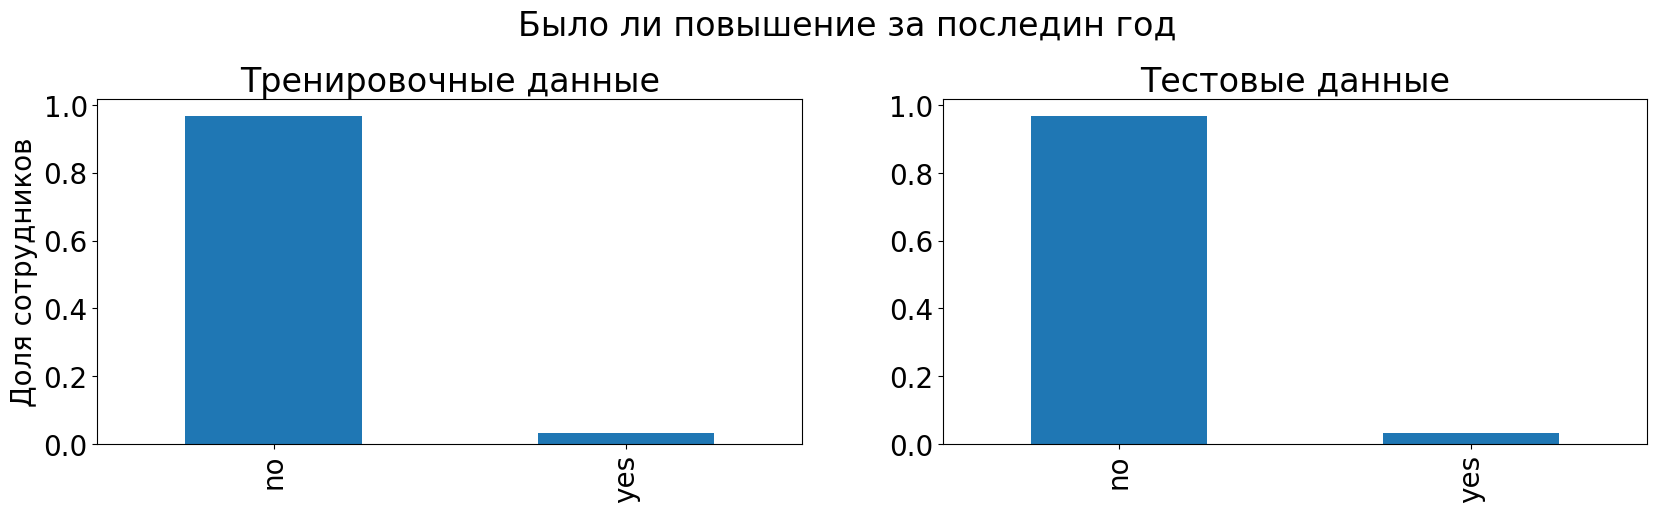

In [29]:
fig, axs = plt.subplots(nrows= 1 , ncols= 2 )
fig.set_size_inches(20, 5)
plt.rcParams['font.size'] = '20'

Xy_train1['last_year_promo'].value_counts(normalize=True).plot(kind='bar',ax=axs[0])
axs[0].set_title('Тренировочные данные')
axs[0].set_ylabel('Доля сотрудников')

X_test1['last_year_promo'].value_counts(normalize=True).plot(kind='bar',ax=axs[1])
axs[1].set_title('Тестовые данные')

fig.suptitle('Было ли повышение за последин год')
plt.subplots_adjust(top= 0.8)
plt.show()

За последний год повышение получило приммерно 3 процента от всех сотрудников. 

#### Last_year_violations

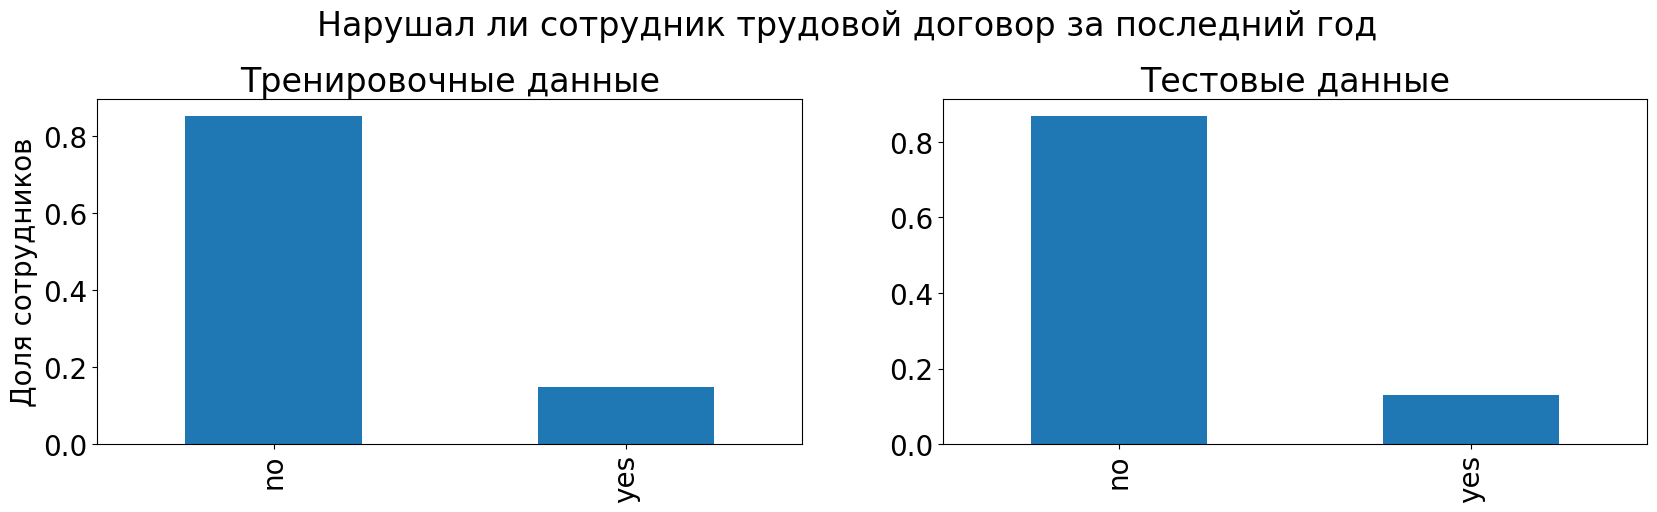

In [30]:
fig, axs = plt.subplots(nrows= 1 , ncols= 2 )
fig.set_size_inches(20, 5)
plt.rcParams['font.size'] = '20'

Xy_train1['last_year_violations'].value_counts(normalize=True).plot(kind='bar',ax=axs[0])
axs[0].set_title('Тренировочные данные')
axs[0].set_ylabel('Доля сотрудников')

X_test1['last_year_violations'].value_counts(normalize=True).plot(kind='bar',ax=axs[1])
axs[1].set_title('Тестовые данные')

fig.suptitle('Нарушал ли сотрудник трудовой договор за последний год')
plt.subplots_adjust(top= 0.8)
plt.show()

За последний год трудовой договор нарушали примерно 14 процентов сотрудников.

#### Supervisor_evaluation

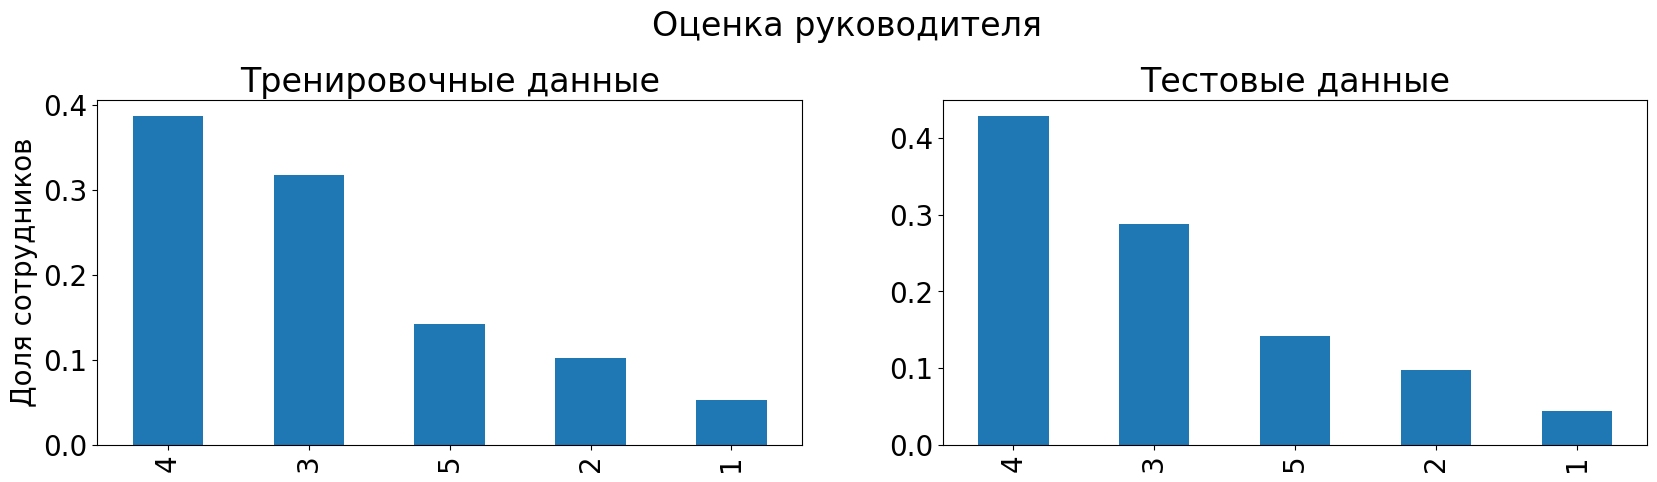

In [31]:
fig, axs = plt.subplots(nrows= 1 , ncols= 2 )
fig.set_size_inches(20, 5)
plt.rcParams['font.size'] = '20'

Xy_train1['supervisor_evaluation'].value_counts(normalize=True).plot(kind='bar',ax=axs[0])
axs[0].set_title('Тренировочные данные')
axs[0].set_ylabel('Доля сотрудников')

X_test1['supervisor_evaluation'].value_counts(normalize=True).plot(kind='bar',ax=axs[1])
axs[1].set_title('Тестовые данные')

fig.suptitle('Оценка руководителя')
plt.subplots_adjust(top= 0.8)
plt.show()

Чаще всего сотридники получают от руководителя оценку 3 или 4.

#### Salary

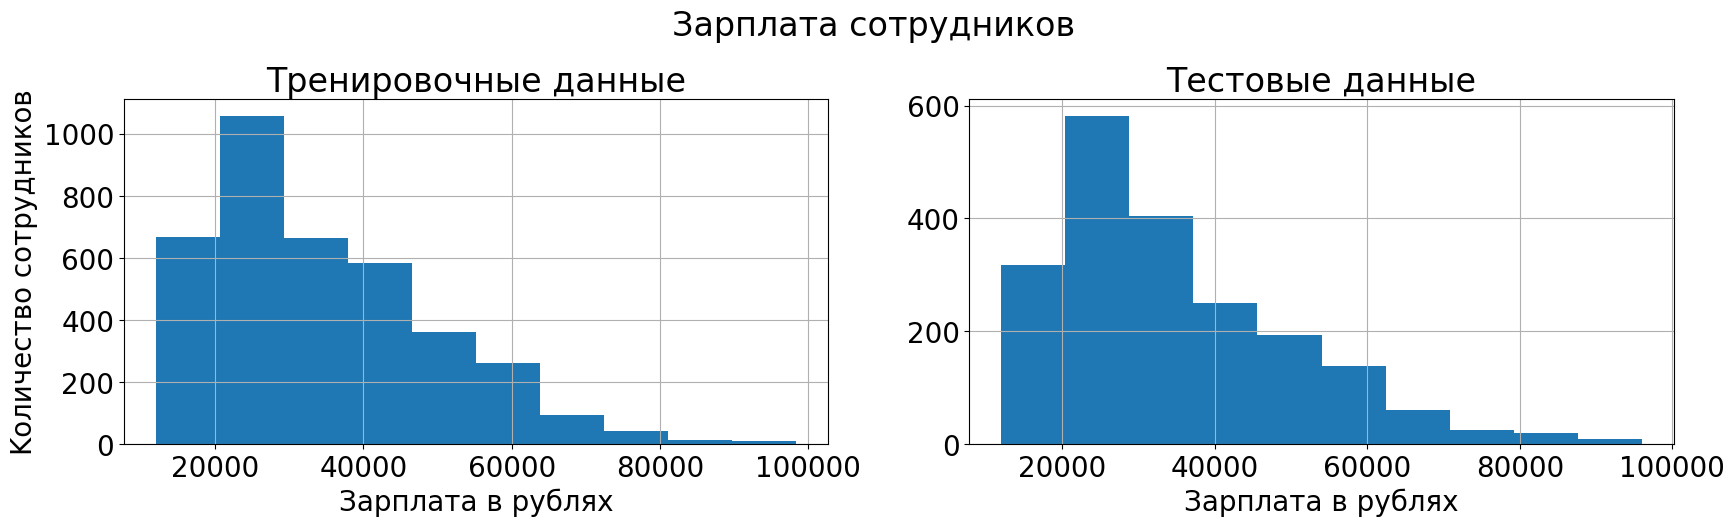

In [32]:
fig, axs = plt.subplots(nrows= 1 , ncols= 2 )
fig.set_size_inches(20, 5)
plt.rcParams['font.size'] = '20'

Xy_train1['salary'].hist(bins=10,ax=axs[0])
axs[0].set_title('Тренировочные данные')
axs[0].set_ylabel('Kоличество сотрудников')
axs[0].set_xlabel('Зарплата в рублях')

X_test1['salary'].hist(ax=axs[1])
axs[1].set_title('Тестовые данные')
axs[1].set_xlabel('Зарплата в рублях')

fig.suptitle('Зарплата сотрудников')
plt.subplots_adjust(top= 0.8)
plt.show()

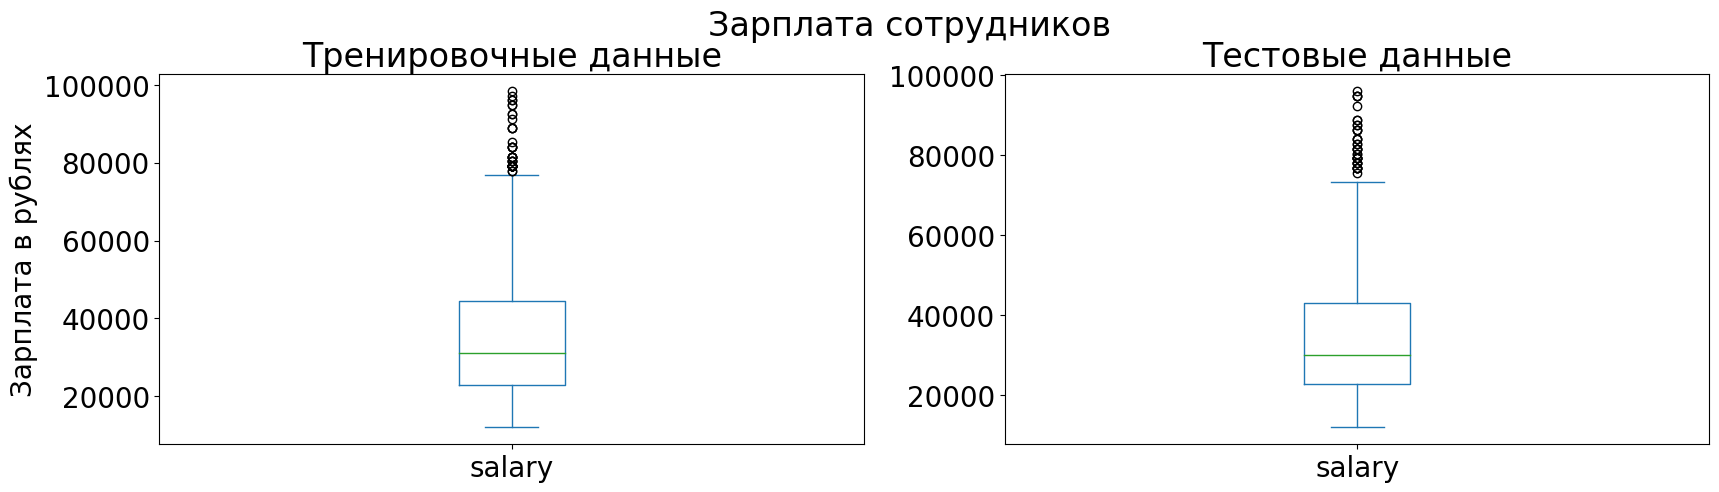

In [33]:
fig, axs = plt.subplots(nrows= 1 , ncols= 2 )
fig.set_size_inches(20, 5)

Xy_train1['salary'].plot(kind='box',ax=axs[0])
axs[0].set_title('Тренировочные данные')
axs[0].set_ylabel('Зарплата в рублях')

X_test1['salary'].plot(kind='box',ax=axs[1])
axs[1].set_title('Тестовые данные')

fig.suptitle('Зарплата сотрудников')
plt.subplots_adjust(top= 0.85 )
plt.show()

In [34]:
Xy_train1[Xy_train1['salary']>70000]['level'].unique()

array(['senior'], dtype=object)

Зарплата большинства сотрудников от 10000 до 40000 рублей. Сотрудники, чья зарплата больше 70 тысяч рублей, имеют уровень sinior.

#### Job_satisfaction_rate

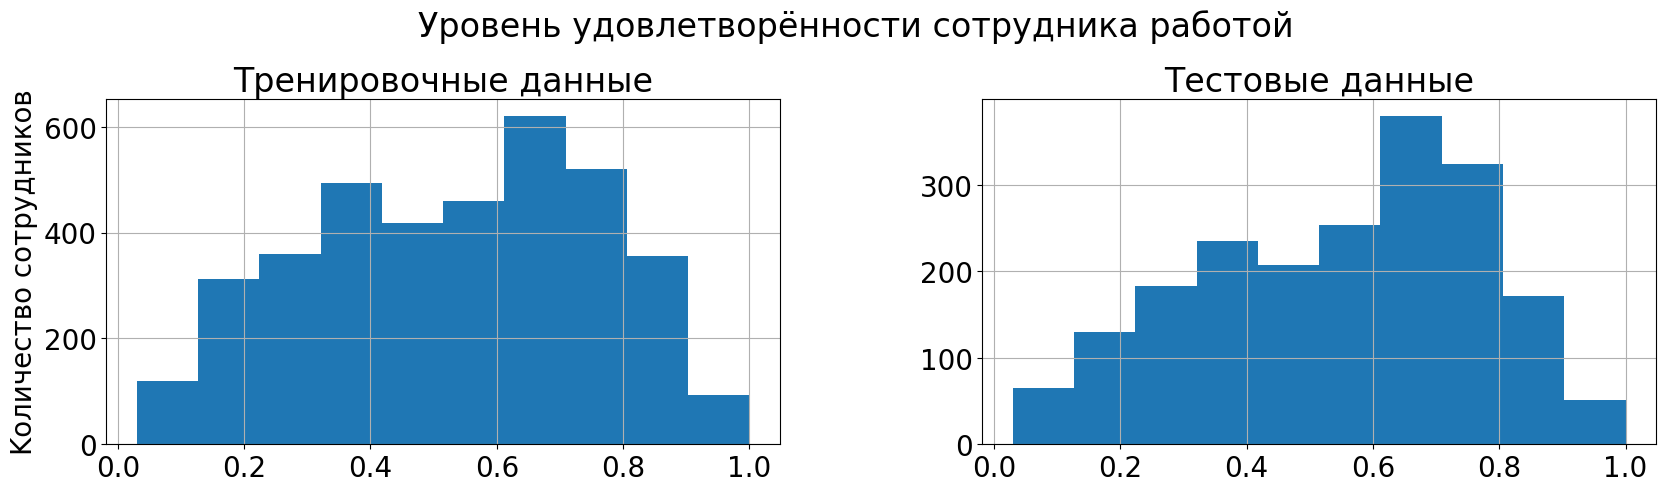

Медианное значения уровня удовлетворенности на тренировочных данных: 0.55


In [35]:
fig, axs = plt.subplots(nrows= 1 , ncols= 2 )
fig.set_size_inches(20, 5)
plt.rcParams['font.size'] = '20'

Xy_train1['job_satisfaction_rate'].hist(bins=10,ax=axs[0])
axs[0].set_title('Тренировочные данные')
axs[0].set_ylabel('Kоличество сотрудников')

y_test1.hist(ax=axs[1])
axs[1].set_title('Тестовые данные')

fig.suptitle('Уровень удовлетворённости сотрудника работой')
plt.subplots_adjust(top= 0.8)
plt.show()

print('Медианное значения уровня удовлетворенности на тренировочных данных:',Xy_train1['job_satisfaction_rate'].median())

Медианное значения уровня удовлетворенности на тренировочных данных: 0.56 - говорит о том,. что количество сотрудников, недовольных работой, почти равно количеству сотрудников, довольных работой.

#### Корреляционный анализ

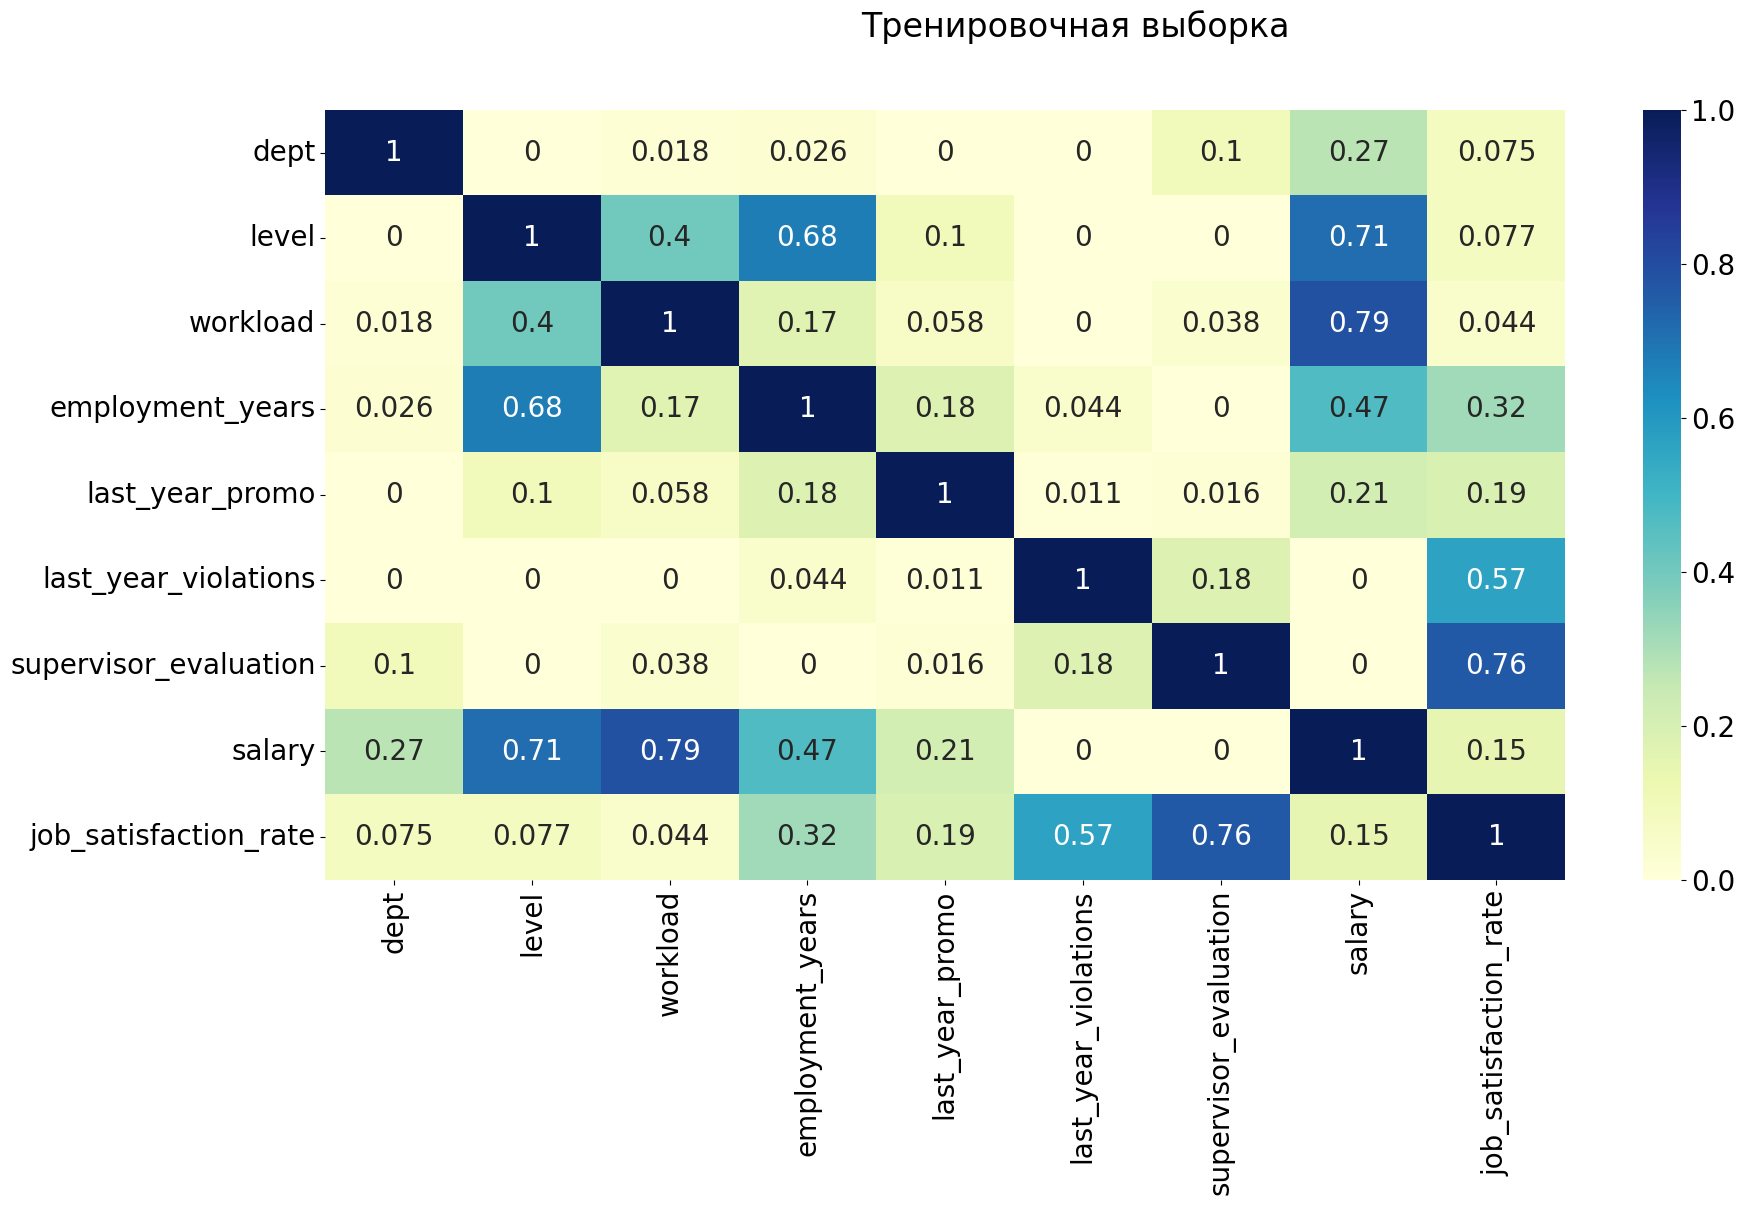

In [36]:
fig, ax = plt.subplots(figsize=(20, 10))
fig.suptitle('Тренировочная выборка')
sns.heatmap(Xy_train1.phik_matrix(interval_cols=['salary','job_satisfaction_rate']), annot=True, cmap='YlGnBu');

In [37]:
Xy_test1 = X_test1.merge(y_test1, right_index=True, left_index=True)
Xy_test1.shape

(2000, 9)

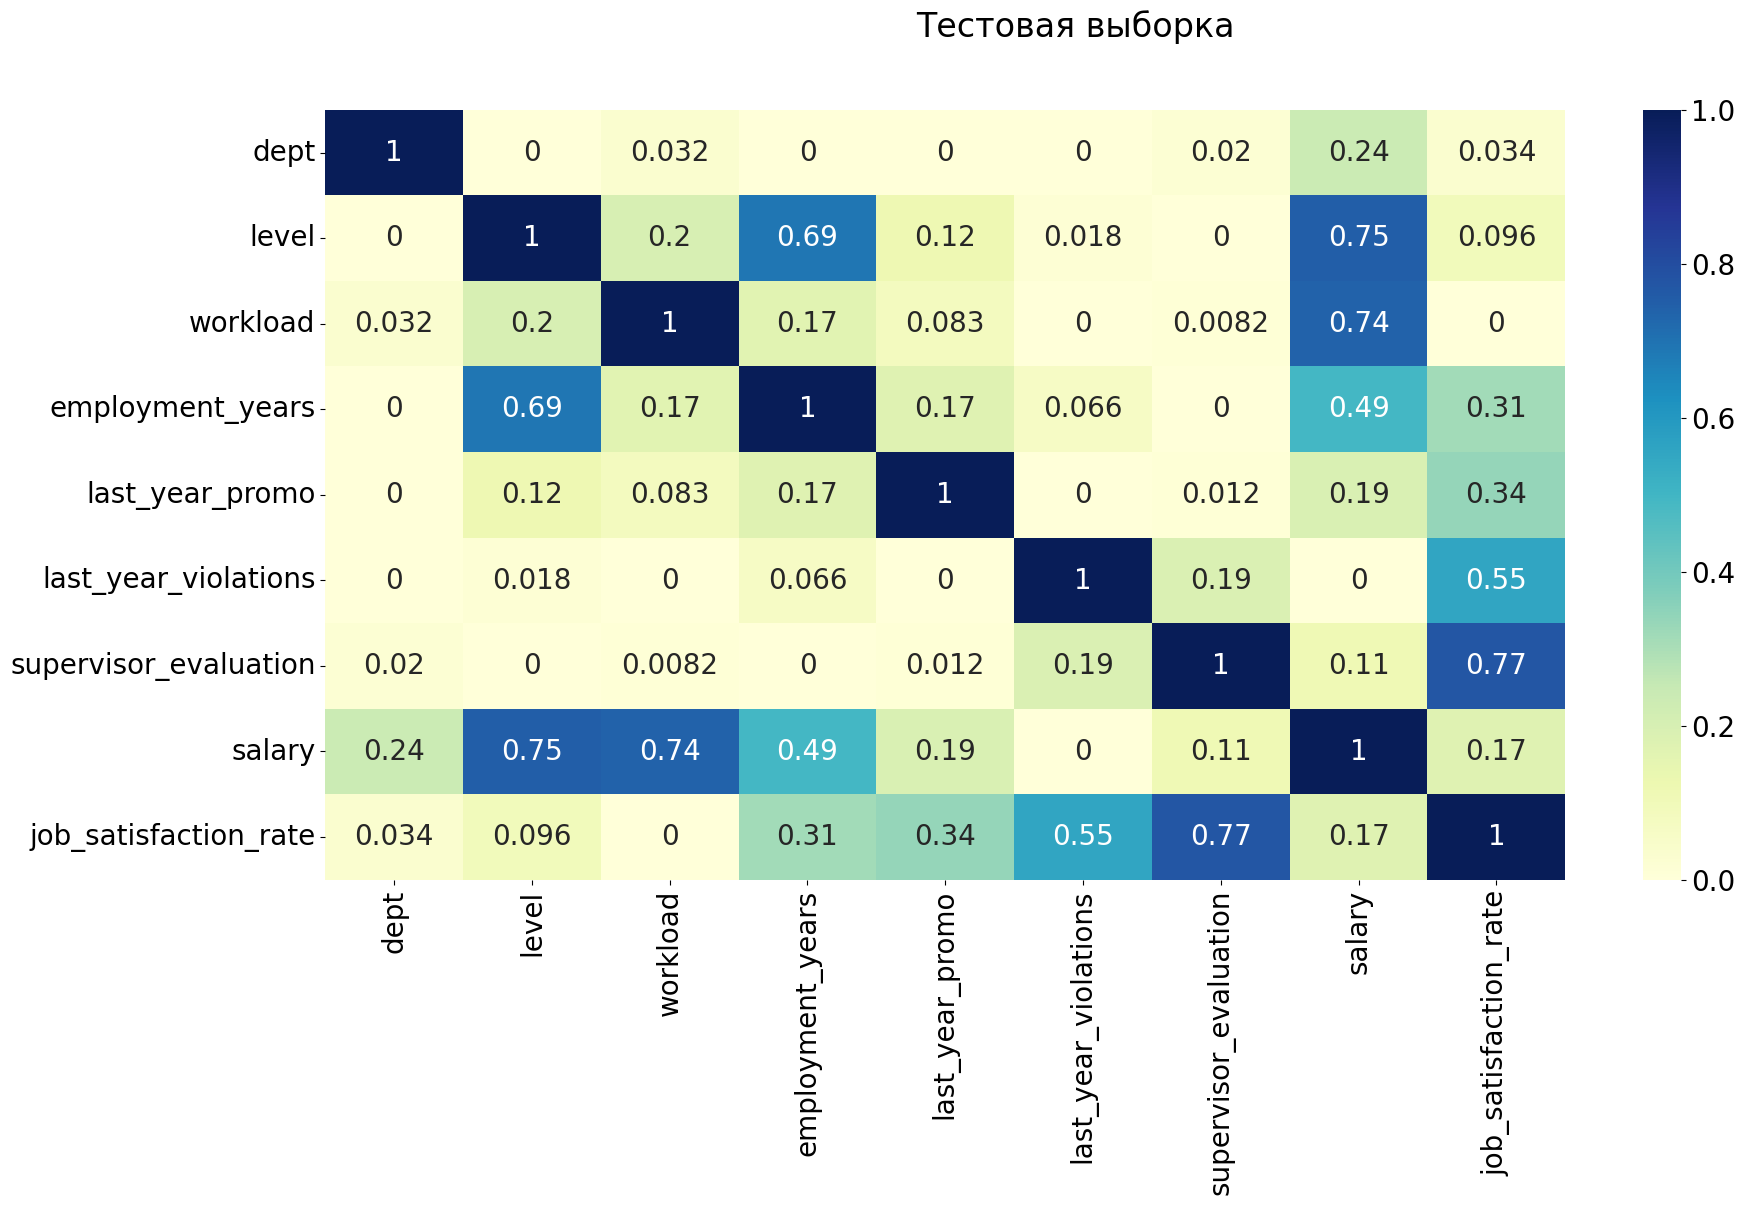

In [38]:
fig, ax = plt.subplots(figsize=(20, 10))
fig.suptitle('Тестовая выборка')
sns.heatmap(Xy_test1.phik_matrix(interval_cols=['salary','job_satisfaction_rate']), annot=True, cmap='YlGnBu');

Уровень должности имеет положительную корреляцию с зарплатой и стажем работы в компании и уровень загруженности положительно коррелирует с зарплатой, что логично, ведь чем дольше и больше сотрудник работает в компании, тем больше опыта он получает и развивает свои навыки, и тем сильнее ценится его работа. Также сильно коррелирует целевой признак с оценкой руководителя. 

#### Вывод

1. Все данные в тренировочной и тестовой выборках имеют одинаковое соотношение.
2. Больше всего сотрудников в отделе продаж.
3. Больше всего в компании джуниор сотрудников и незначительно меньше мидл сотрудников.
4. В основном у сотрудников средний уровень загруженности.
5. Большинство сотрудников работают в компании 1-2 года.
6. Чаще всего сотридники получают от руководителя оценку 3 или 4.
7. За последний год повышение получило приммерно 3%  от всех сотрудников. 
8. За последний год трудовой договор нарушали примерно 14 процентов сотрудников.
9. Зарплата большинства сотрудников от 10000 до 40000 рублей. Сотрудники, чья зарплата больше 70 тысяч рублей, имеют уровень sinior.
10. Количество сотрудников, недовольных работой, почти равно количеству сотрудников, довольных работой.
11. Уровень должности имеет положительную корреляцию с зарплатой и стажем работы в компании и уровень загруженности положительно коррелирует с зарплатой. Также сильно коррелирует целевой признак с оценкой руководителя. 

На следующем шаге произведем кодирование и мастабирование признаков. `level`,`workload` - порядковые признаки, их будем кодировать OrdinalEncoder. Остальные качественные признаки закодируем с помощью OneHotEncoder. Количественные признаки будем масштабировать StandardScaler или MinMaxScaler.

### Подготовка данных

Кодировать и масштабировать данные будем в пайплайне. Разделим признаки для разных кодировщиков.

In [39]:
ohe_col = ['dept','last_year_promo','last_year_violations']
ord_col = ['level','workload']
num_col = ['employment_years','supervisor_evaluation','salary']

Также в пайплайне заменим пропущенные значения модой, используя SimpleImputer.

In [40]:
ohe_pip = Pipeline([
    ( 'simpleImputer_ohe_nan', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent') 
    ),
    ( 'simpleImputer_ohe_blank',
             SimpleImputer(missing_values=' ', strategy='most_frequent')
    ),
    ( 'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)
    )
])

In [41]:
ord_pip = Pipeline([
    ('simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
    ('ord',  
            OrdinalEncoder(
                categories=[
                    ['junior','middle','senior'], 
                    ['low','medium','high']
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
    ('simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
])

In [42]:
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pip, ohe_col),
     ('ord', ord_pip, ord_col),
     ('num', StandardScaler(), num_col)
    ], 
    remainder='passthrough'
)

Мы создали пайплайн для обработки данных. Применим его в следующем шаге вместе с обучением модели.

### Обучение модели

In [43]:
X_train1 = Xy_train1.drop('job_satisfaction_rate', axis=1)
y_train1 = Xy_train1['job_satisfaction_rate']

оставим финальный пайплайн. Будем использовать две модели: линейную регрессию и дерево решений. У дерева будем подбирать различные параметры

In [44]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
])

In [45]:
param_grid = [
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(10,25),
        'models__max_features': range(2,9),
        'models__min_samples_split': [2,3,5,10],
        'models__min_samples_leaf': [1,2,3,4,5]
    },
    {
        'models': [LinearRegression()]
    }
]

Для оценки качества работы модели будем использовать SMAPE. Напишем функцию для нее.

In [46]:
def smape(y_true, y_pred):
    s = abs(y_true-y_pred)/((abs(y_true)+abs(y_pred))/2)
    return (100/len(y_true)) * sum(s)

SMAPE = make_scorer(smape, greater_is_better=False)

In [47]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring=SMAPE, 
    n_jobs=-1
)

randomized_search.fit(X_train1, y_train1)

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe_nan',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('simpleImputer_ohe_blank',
                                                                                                SimpleImputer(missing_values=' ',
                                                                                                              strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ign...
                                              DecisionTreeRegressor(random_state=42))]),
                   n_jobs=-1,
                   param_distributions=[{'models': [DecisionTreeRegressor(random_state=42)],
                                         'models__max_depth': range(10, 25),
                                         'models__max_features': range(2, 9),
                                         'models__min_samples_leaf': [1, 2, 3,
                                                                      4, 5],
                                         'models__min_samples_split': [2, 3, 5,
                                                                       10]},
                                        {'models': [LinearRegression()]}],
                   scoring=make_scorer(smape, greater_is_better=False))

In [48]:
print('Метрика SMAPE для лучшей модели:\n', -randomized_search.best_score_)
print('\nЛучшая модель и её параметры:\n\n', randomized_search.best_estimator_) 

Метрика SMAPE для лучшей модели:
 15.148385306732019

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe_nan',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('simpleImputer_ohe_blank',
                                                                   SimpleImputer(missing_values=' ',
                                                                                 strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_un

Лучшей моделью оказалось дерево решений. Проверим метрику на тестовых данных.

In [49]:
y_pred1 = randomized_search.predict(X_test1)

In [50]:
y_test1 = y_test1['job_satisfaction_rate']

In [51]:
print('Значение метрики SMAPE на тестовых данных:',smape(y_test1 ,y_pred1))

Значение метрики SMAPE на тестовых данных: 13.779127297496153


Наш критерий успеха - метрика меньше 15. Мы добились нужного результата. Проведем анализ важности признаков.

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


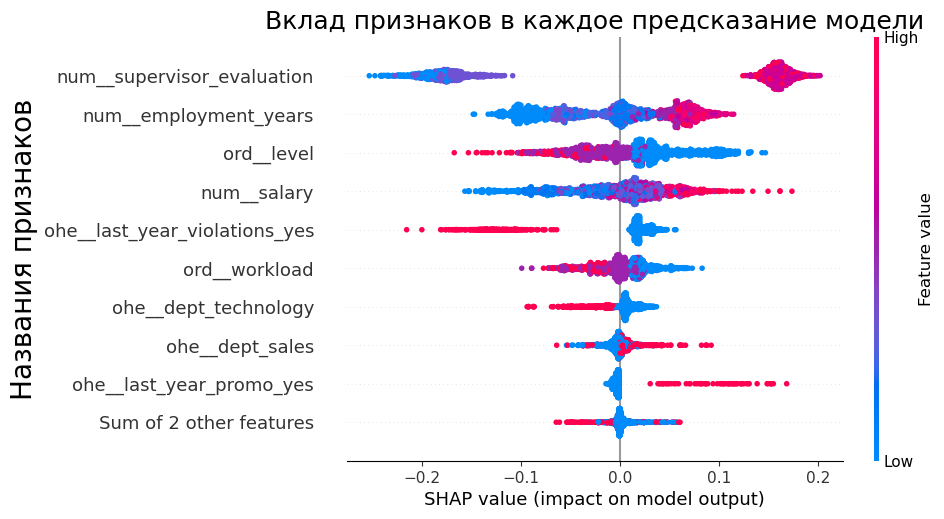

In [52]:
x_train1 = pipe_final.named_steps['preprocessor'].fit_transform(X_train1)
x_test1 = pipe_final.named_steps['preprocessor'].transform(X_test1)

explainer = shap.TreeExplainer(randomized_search.best_estimator_.named_steps['models'])

feature_names = pipe_final.named_steps['preprocessor'].get_feature_names_out()
x_test1 = pd.DataFrame(x_test1, columns=feature_names)

shap_values = explainer(x_test1)

shap.plots.beeswarm(shap_values, show=False) 

plt.rcParams['font.size'] = '15'
plt.title('Вклад признаков в каждое предсказание модели')
plt.ylabel('Названия признаков')
plt.show()

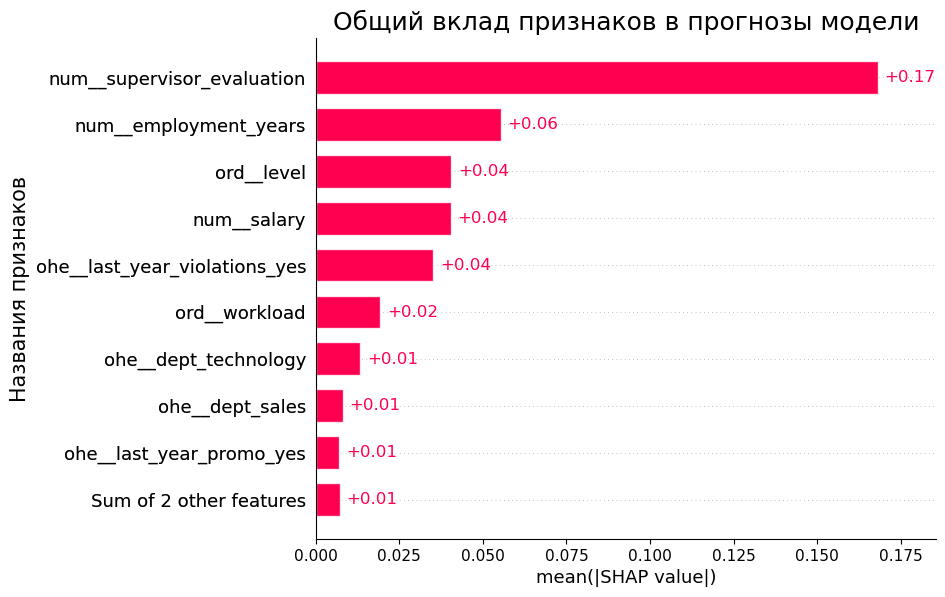

In [53]:
shap.plots.bar(shap_values,show=False)
plt.rcParams['font.size'] = '15'
plt.title('Общий вклад признаков в прогнозы модели')
plt.ylabel('Названия признаков')
plt.show()

Больше всего на результат модели влияет `supervisor_evaluation`. Чем выше оценка руководителя, тем вероятнее сотрудник будет удовлетворен работой.

### Вывод

Мы выполнили первую задачу: построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика.
Для этого мы подготовили данные:
1. Рейтинговые переменные в столбцах `level` и `workload` кодировали с помощью OrdinalEncoder
2. Остальные качественные признаки кодировали с помощью OneHotEncoder
3. Количественные признаки маштабировали, используя StandardScaler

При поиске лучшего результата использовали две модели: линейную регрессию и дерево решений. У дерева подбирали различные параметры. Победило дерево решений: метрика на тренировочных данных - 15.3, на тестовых - 14.4. Линейная регрессия достаточно простая модель, которая сильно зависит от данных (от выбросов, от масштабирования). Дерево решений в этом смысле устойчивее, и оно ищет взаимосвязи, которые упускают линейные модели.

## Задача 2

### Загрузка данных

In [56]:
Xy_train2 = pd.read_csv('C:/FATHER/datasets/train_quit.csv')
X_test2 = pd.read_csv('C:/FATHER/datasets/test_features.csv')
y_test2 = pd.read_csv('C:/FATHER/datasets/test_target_quit.csv')

In [57]:
description(Xy_train2)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


In [58]:
X_test2 = X_test2.sort_values('id')
description(X_test2)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
1172,100298,hr,junior,low,2,no,no,4,19200
852,100480,marketing,junior,low,4,no,no,4,16800
848,100503,purchasing,middle,high,5,no,no,4,55200
524,100610,sales,middle,medium,5,no,no,4,43200
476,100692,sales,middle,high,6,no,no,4,48000


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 1172 to 1844
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 156.2+ KB


In [59]:
y_test2 = y_test2.sort_values('id')
description(y_test2)

,id,quit
1566,100298,no
491,100480,no
802,100503,no
725,100610,no
319,100692,no


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 1566 to 0
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 46.9+ KB


**Вывод:** Данные содержат те же признаки, что и данные для первой задачи. Однако изменен целевой признак: `quit` - увольнение сотрудника из компании.

### Предобработка данных

#### Xy_train2
Проверим все признаки на наличие "разночтений", внесем id в индексы и проверим есть ли дубликаты.

In [60]:
col = ['dept','level','workload','last_year_promo','last_year_violations']

In [61]:
uniq(Xy_train2, col)

dept ['sales' 'purchasing' 'marketing' 'technology' 'hr']
level ['middle' 'junior' 'sinior']
workload ['high' 'medium' 'low']
last_year_promo ['no' 'yes']
last_year_violations ['no' 'yes']


In [62]:
Xy_train2['level'] = Xy_train2['level'].replace('sinior','senior')

In [63]:
Xy_train2.duplicated('id').sum()

0

In [64]:
Xy_train2 = Xy_train2.set_index('id')
Xy_train2.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
id,,,,,,,,,
723290,sales,middle,high,2,no,no,4,54000,no
814010,sales,junior,medium,2,no,no,4,27600,no
155091,purchasing,middle,medium,5,no,no,1,37200,no
257132,sales,junior,medium,2,no,yes,3,24000,yes
910140,marketing,junior,medium,2,no,no,5,25200,no


In [65]:
Xy_train2.duplicated().sum()

1413

In [66]:
Xy_train2['quit'].value_counts()

no     2872
yes    1128
Name: quit, dtype: int64

Так как в данных присутствует сильный дисбаланс классов, удалим дубликаты только в большем классе. 

In [67]:
Xy_train2[Xy_train2['quit']=='no'].duplicated().sum()

940

In [68]:
Xy_train2_no = Xy_train2[Xy_train2['quit']=='no'].drop_duplicates()

In [69]:
Xy_train2 = shuffle(pd.concat([Xy_train2_no, Xy_train2[Xy_train2['quit']=='yes']]))

In [70]:
Xy_train2.shape

(3060, 9)

#### X_test2
Сделаем то же для других датасетов.

In [71]:
uniq(X_test2, col)

dept ['hr' 'marketing' 'purchasing' 'sales' 'technology' nan ' ']
level ['junior' 'middle' 'sinior' nan]
workload ['low' 'high' 'medium' ' ']
last_year_promo ['no' 'yes']
last_year_violations ['no' 'yes']


In [72]:
X_test2['level'] = X_test2['level'].replace('sinior','senior')

In [73]:
X_test2.duplicated('id').sum()

0

In [74]:
X_test2 = X_test2.set_index('id')
X_test2.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
id,,,,,,,,
100298,hr,junior,low,2,no,no,4,19200
100480,marketing,junior,low,4,no,no,4,16800
100503,purchasing,middle,high,5,no,no,4,55200
100610,sales,middle,medium,5,no,no,4,43200
100692,sales,middle,high,6,no,no,4,48000


#### y_test2

In [75]:
y_test2['quit'].unique()

array(['no', 'yes'], dtype=object)

In [76]:
y_test2.duplicated('id').sum()

0

In [77]:
y_test2 = y_test2.set_index('id')
y_test2.head()

,quit
id,
100298,no
100480,no
100503,no
100610,no
100692,no


**Вывод:** В датасете `X_test2` присутствуют пропуски, которые мы заполним в следующих шагах в пайплайне.

### Исследовательский анализ данных

Проведем исследовательский анализ данных на датасете `Xy_train2`, разделяя его по целевому признаку.

In [78]:
quit_yes = Xy_train2[Xy_train2['quit']=='yes']
quit_no = Xy_train2[Xy_train2['quit']=='no']

#### Dept

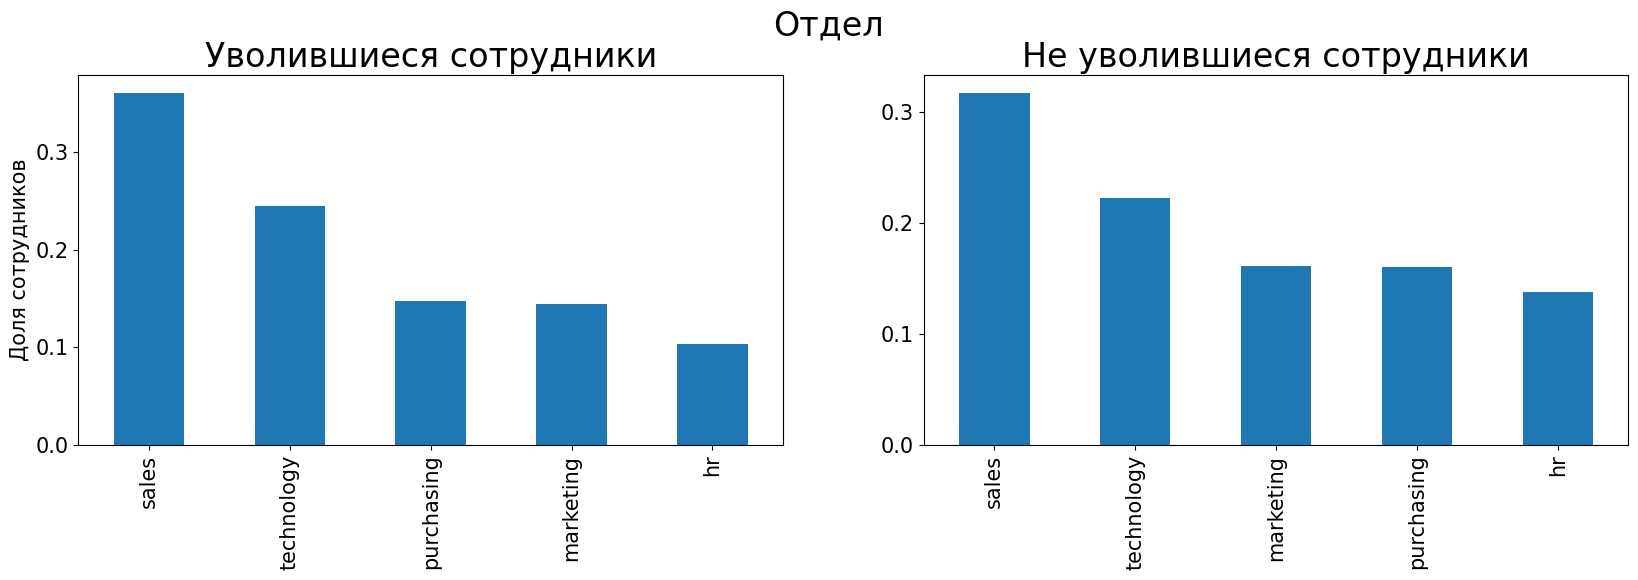

In [79]:
fig, axs = plt.subplots(nrows= 1 , ncols= 2 )
fig.set_size_inches(20, 5)
plt.rcParams['font.size'] = '20'

quit_yes['dept'].value_counts(normalize=True).plot(kind='bar',ax=axs[0])
axs[0].set_title('Уволившиеся сотрудники')
axs[0].set_ylabel('Доля сотрудников')

quit_no['dept'].value_counts(normalize=True).plot(kind='bar',ax=axs[1])
axs[1].set_title('Не уволившиеся сотрудники')

fig.suptitle('Отдел')
plt.subplots_adjust(top= 0.85)
plt.show()

Количество уволившихся и не уволившихся сотрудников в отделах распределены одинаково. Больше всего сотрудников в отделе продаж.

#### Level

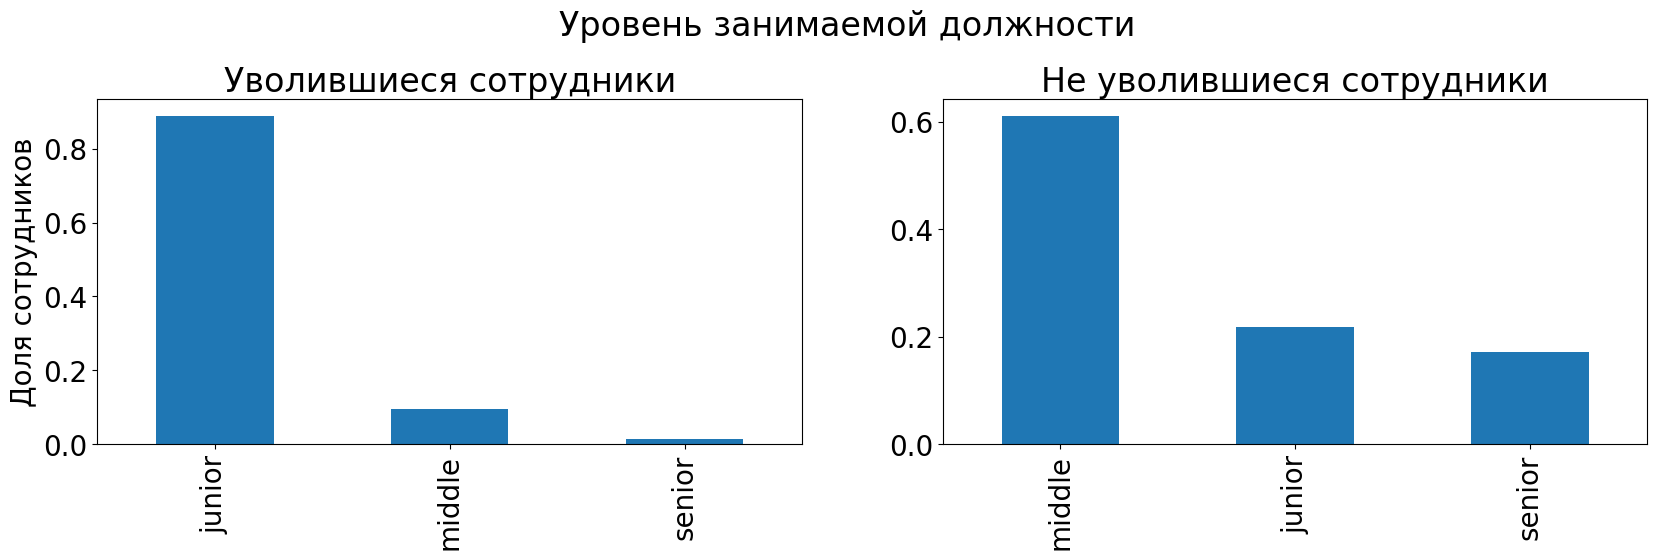

In [80]:
fig, axs = plt.subplots(nrows= 1 , ncols= 2 )
fig.set_size_inches(20, 5)
plt.rcParams['font.size'] = '20'

quit_yes['level'].value_counts(normalize=True).plot(kind='bar',ax=axs[0])
axs[0].set_title('Уволившиеся сотрудники')
axs[0].set_ylabel('Доля сотрудников')

quit_no['level'].value_counts(normalize=True).plot(kind='bar',ax=axs[1])
axs[1].set_title('Не уволившиеся сотрудники')

fig.suptitle('Уровень занимаемой должности')
plt.subplots_adjust(top= 0.8)
plt.show()

Большинство уволившихся сотрудников джуны. Большинство оставшихся сотрудников в компании занимают должность уровня мидл.

#### Workload

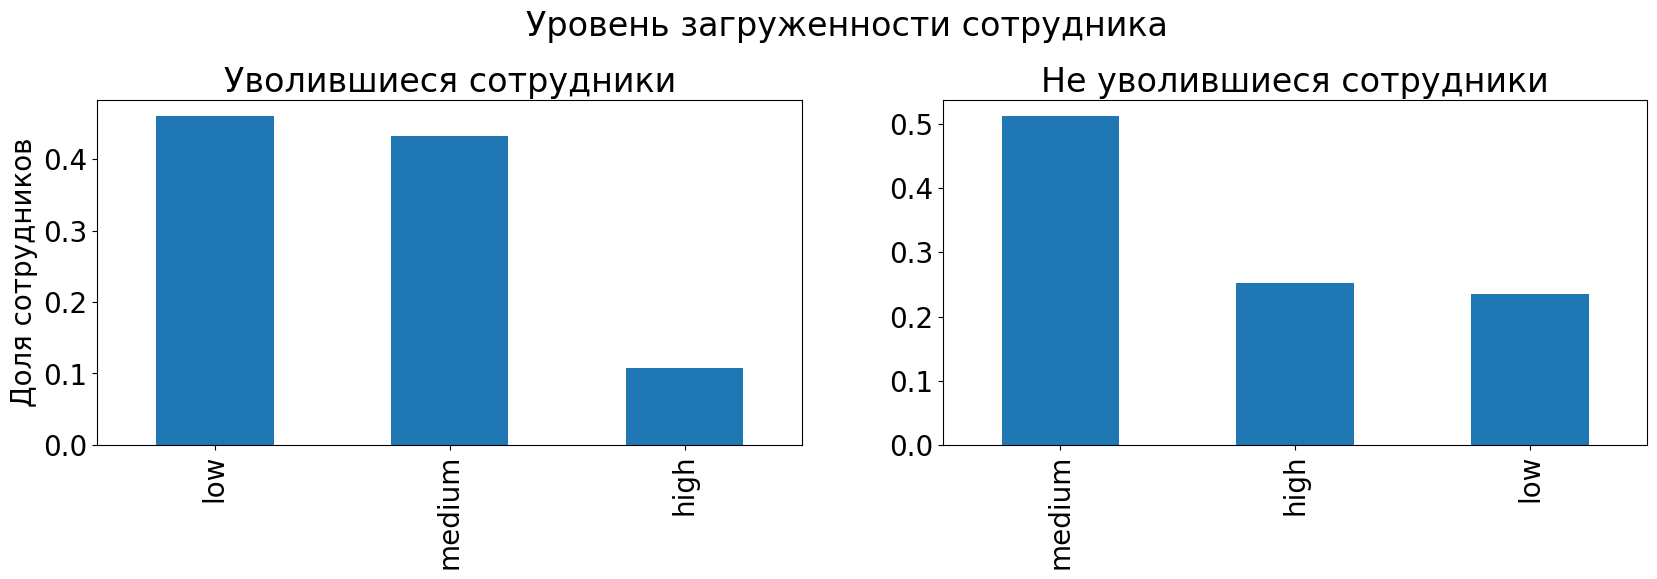

In [81]:
fig, axs = plt.subplots(nrows= 1 , ncols= 2 )
fig.set_size_inches(20, 5)
plt.rcParams['font.size'] = '20'

quit_yes['workload'].value_counts(normalize=True).plot(kind='bar',ax=axs[0])
axs[0].set_title('Уволившиеся сотрудники')
axs[0].set_ylabel('Доля сотрудников')

quit_no['workload'].value_counts(normalize=True).plot(kind='bar',ax=axs[1])
axs[1].set_title('Не уволившиеся сотрудники')

fig.suptitle('Уровень загруженности сотрудника')
plt.subplots_adjust(top= 0.8)
plt.show()

Более 500 уволившихся сотрудников имели низкую загруженность. Скорее всего, это связано с тем, что их уровень был junior.

#### Employment_years

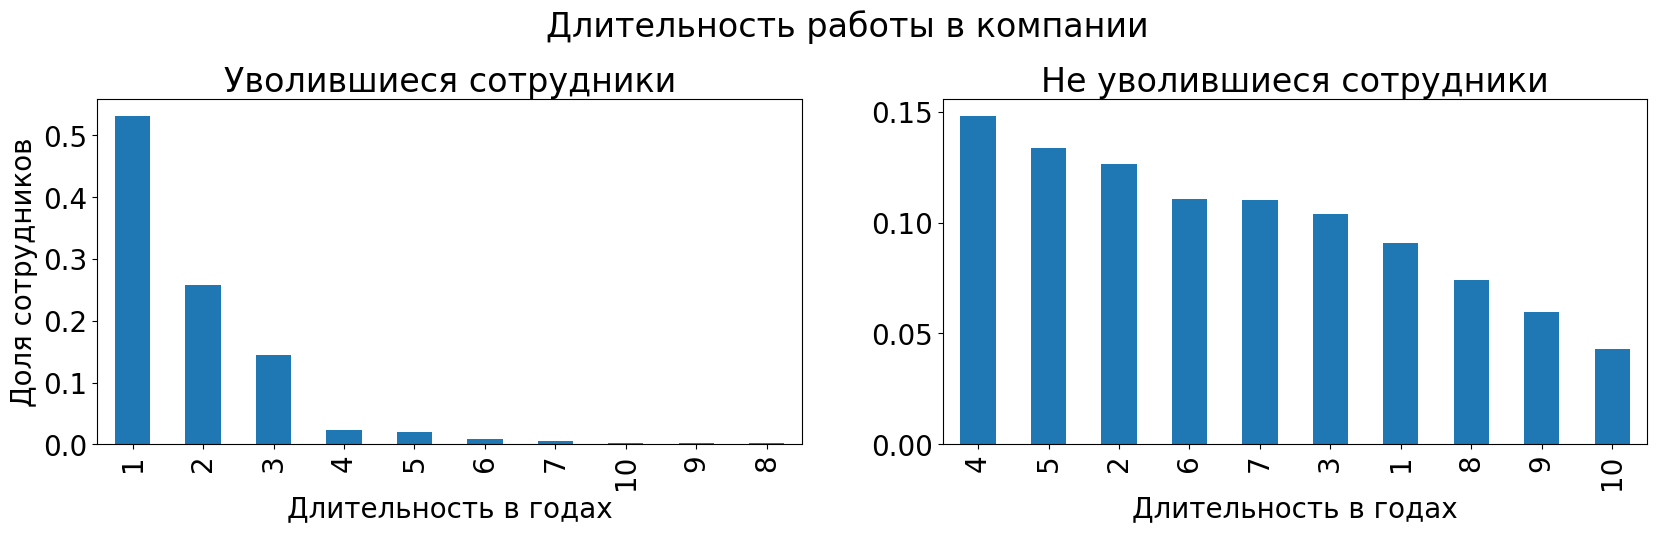

In [82]:
fig, axs = plt.subplots(nrows= 1 , ncols= 2 )
fig.set_size_inches(20, 5)
plt.rcParams['font.size'] = '20'

quit_yes['employment_years'].value_counts(normalize=True).plot(kind='bar',ax=axs[0])
axs[0].set_title('Уволившиеся сотрудники')
axs[0].set_ylabel('Доля сотрудников')
axs[0].set_xlabel('Длительность в годах')

quit_no['employment_years'].value_counts(normalize=True).plot(kind='bar',ax=axs[1])
axs[1].set_title('Не уволившиеся сотрудники')
axs[1].set_xlabel('Длительность в годах')

fig.suptitle('Длительность работы в компании')
plt.subplots_adjust(top= 0.8)
plt.show()

Большинство уволившихся сотрудников работали не больше 3 лет в компании. 

#### Last_year_promo

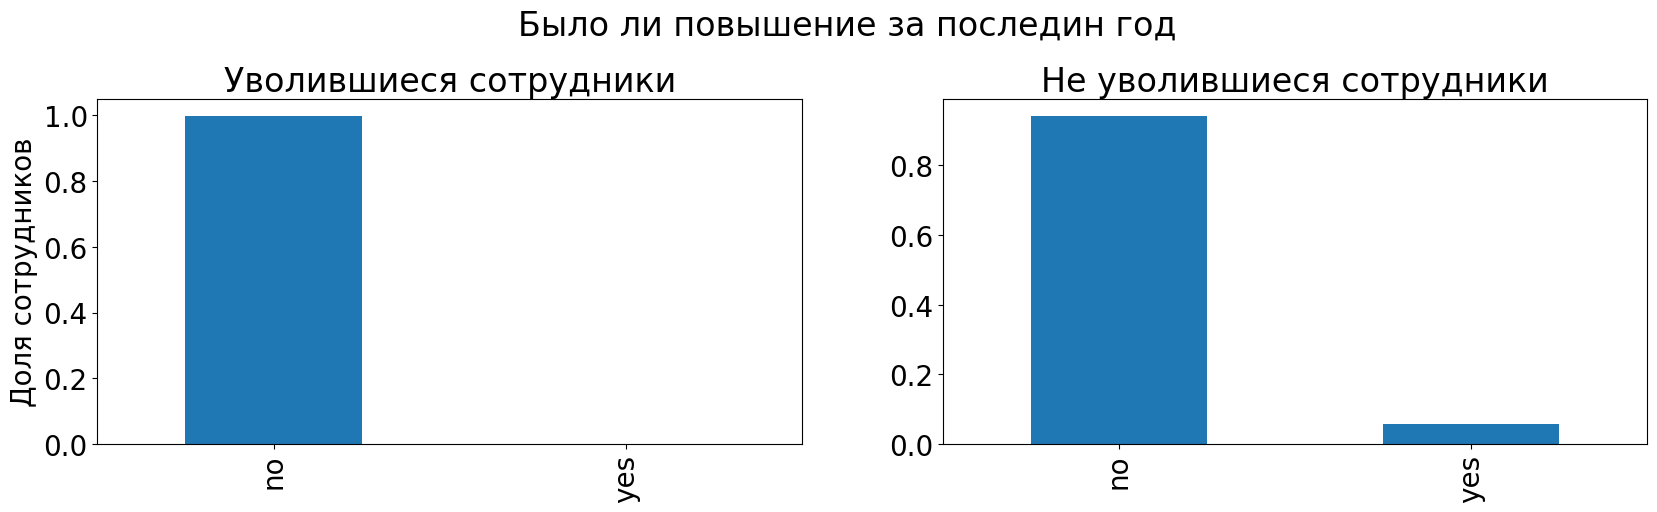

In [83]:
fig, axs = plt.subplots(nrows= 1 , ncols= 2 )
fig.set_size_inches(20, 5)
plt.rcParams['font.size'] = '20'

quit_yes['last_year_promo'].value_counts(normalize=True).plot(kind='bar',ax=axs[0])
axs[0].set_title('Уволившиеся сотрудники')
axs[0].set_ylabel('Доля сотрудников')

quit_no['last_year_promo'].value_counts(normalize=True).plot(kind='bar',ax=axs[1])
axs[1].set_title('Не уволившиеся сотрудники')

fig.suptitle('Было ли повышение за последин год')
plt.subplots_adjust(top= 0.8)
plt.show()

Сотрудники, получавшие повышение, составляют незначительную часть от свего количества. 

#### Last_year_violations

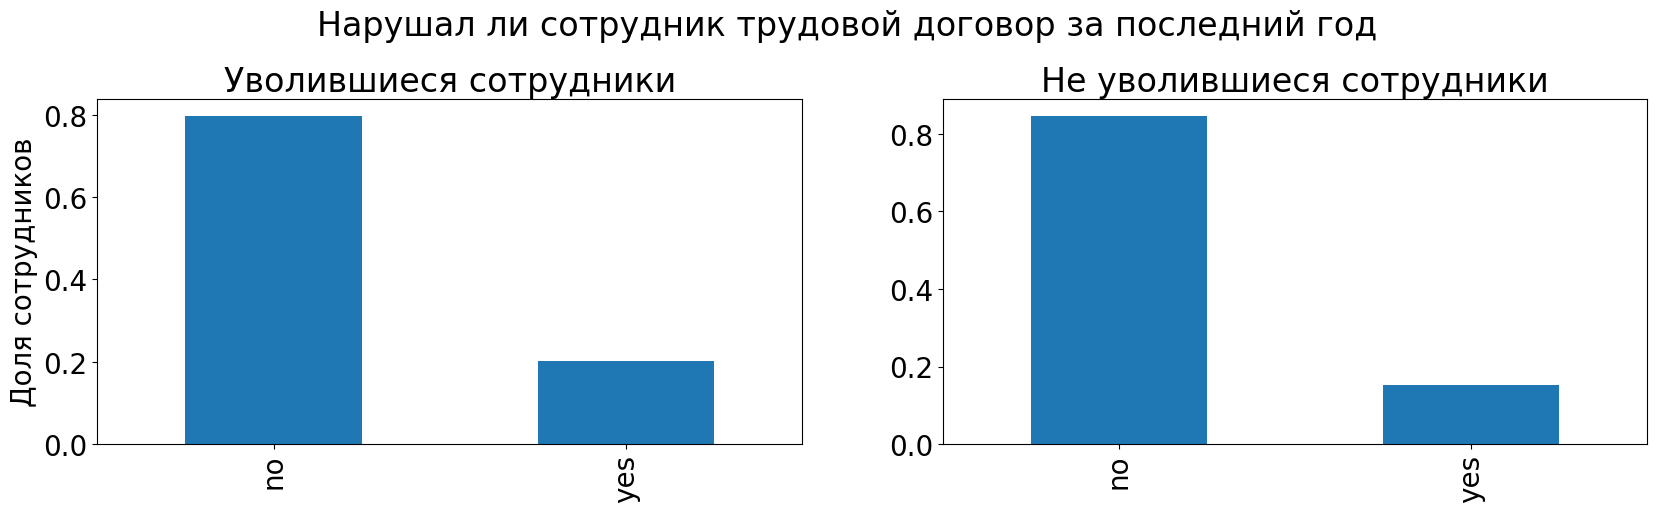

In [84]:
fig, axs = plt.subplots(nrows= 1 , ncols= 2 )
fig.set_size_inches(20, 5)
plt.rcParams['font.size'] = '20'

quit_yes['last_year_violations'].value_counts(normalize=True).plot(kind='bar',ax=axs[0])
axs[0].set_title('Уволившиеся сотрудники')
axs[0].set_ylabel('Доля сотрудников')

quit_no['last_year_violations'].value_counts(normalize=True).plot(kind='bar',ax=axs[1])
axs[1].set_title('Не уволившиеся сотрудники')

fig.suptitle('Нарушал ли сотрудник трудовой договор за последний год')
plt.subplots_adjust(top= 0.8)
plt.show()

#### Supervisor_evaluation

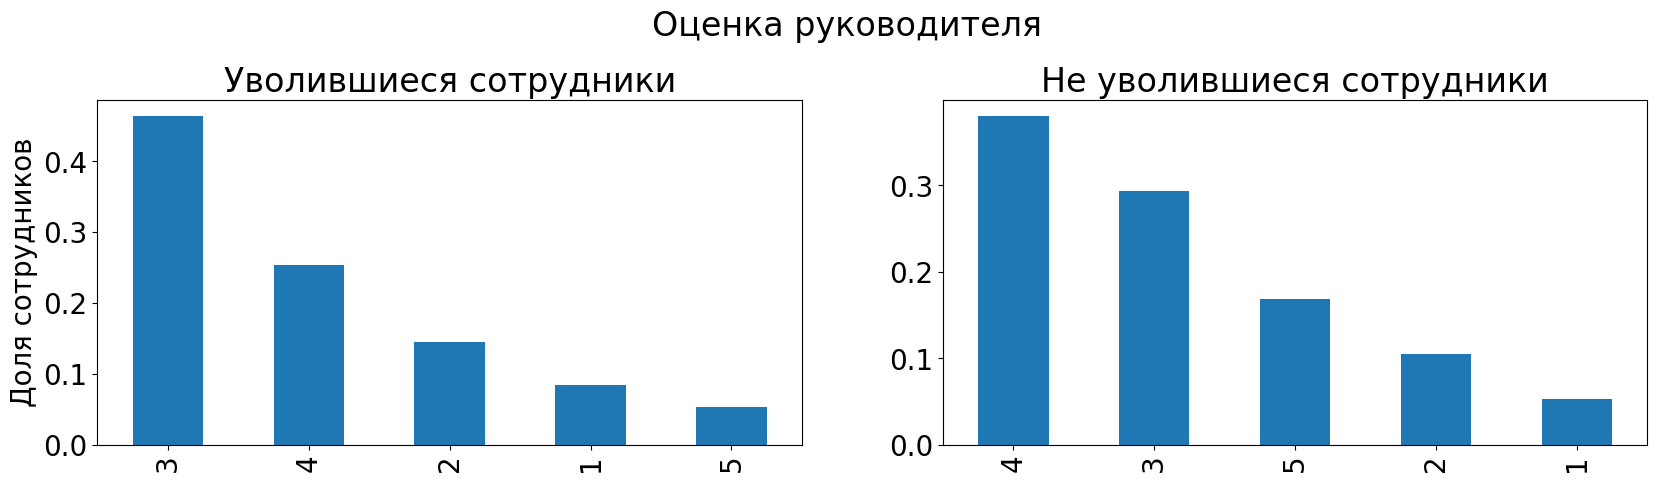

In [85]:
fig, axs = plt.subplots(nrows= 1 , ncols= 2 )
fig.set_size_inches(20, 5)
plt.rcParams['font.size'] = '20'

quit_yes['supervisor_evaluation'].value_counts(normalize=True).plot(kind='bar',ax=axs[0])
axs[0].set_title('Уволившиеся сотрудники')
axs[0].set_ylabel('Доля сотрудников')

quit_no['supervisor_evaluation'].value_counts(normalize=True).plot(kind='bar',ax=axs[1])
axs[1].set_title('Не уволившиеся сотрудники')

fig.suptitle('Оценка руководителя')
plt.subplots_adjust(top= 0.8)
plt.show()

Уволившиеся сотрудники чаще получали оценку 3 от руковедителя, не уволившиеся сотрудники - 4.

#### Salary

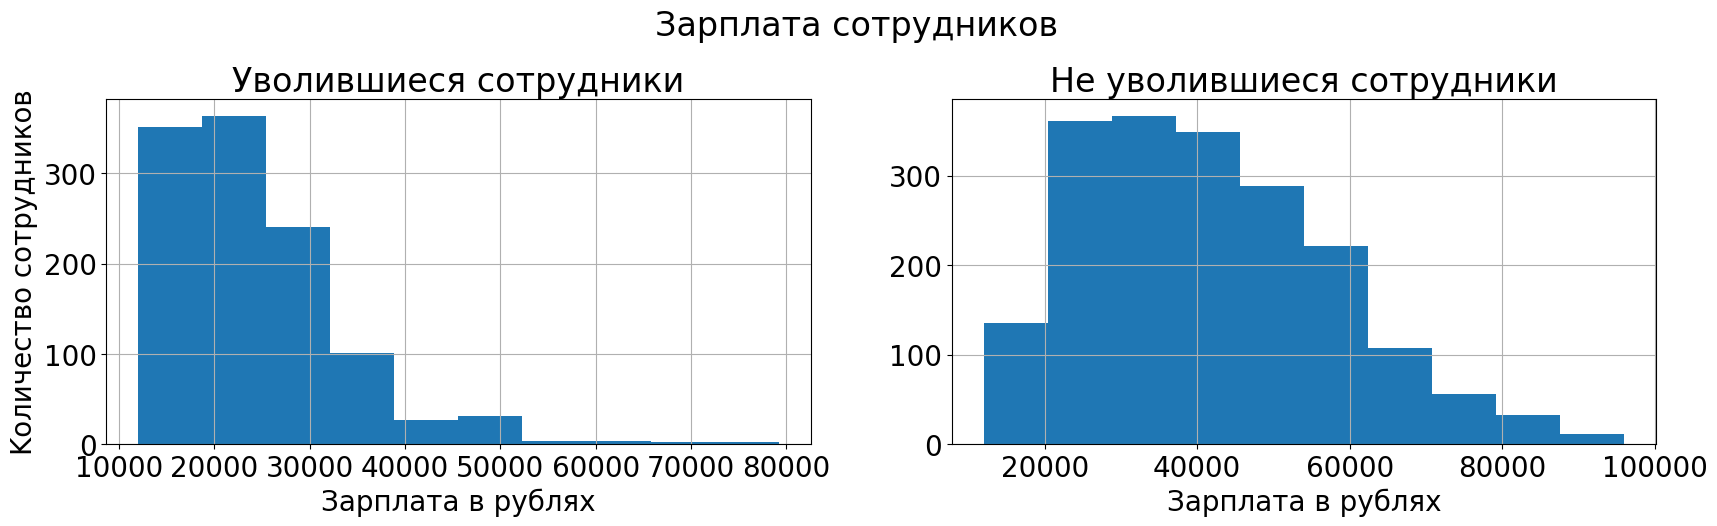

In [86]:
fig, axs = plt.subplots(nrows= 1 , ncols= 2 )
fig.set_size_inches(20, 5)
plt.rcParams['font.size'] = '20'

quit_yes['salary'].hist(bins=10,ax=axs[0])
axs[0].set_title('Уволившиеся сотрудники')
axs[0].set_ylabel('Kоличество сотрудников')
axs[0].set_xlabel('Зарплата в рублях')

quit_no['salary'].hist(ax=axs[1])
axs[1].set_title('Не уволившиеся сотрудники')
axs[1].set_xlabel('Зарплата в рублях')

fig.suptitle('Зарплата сотрудников')
plt.subplots_adjust(top= 0.8)
plt.show()

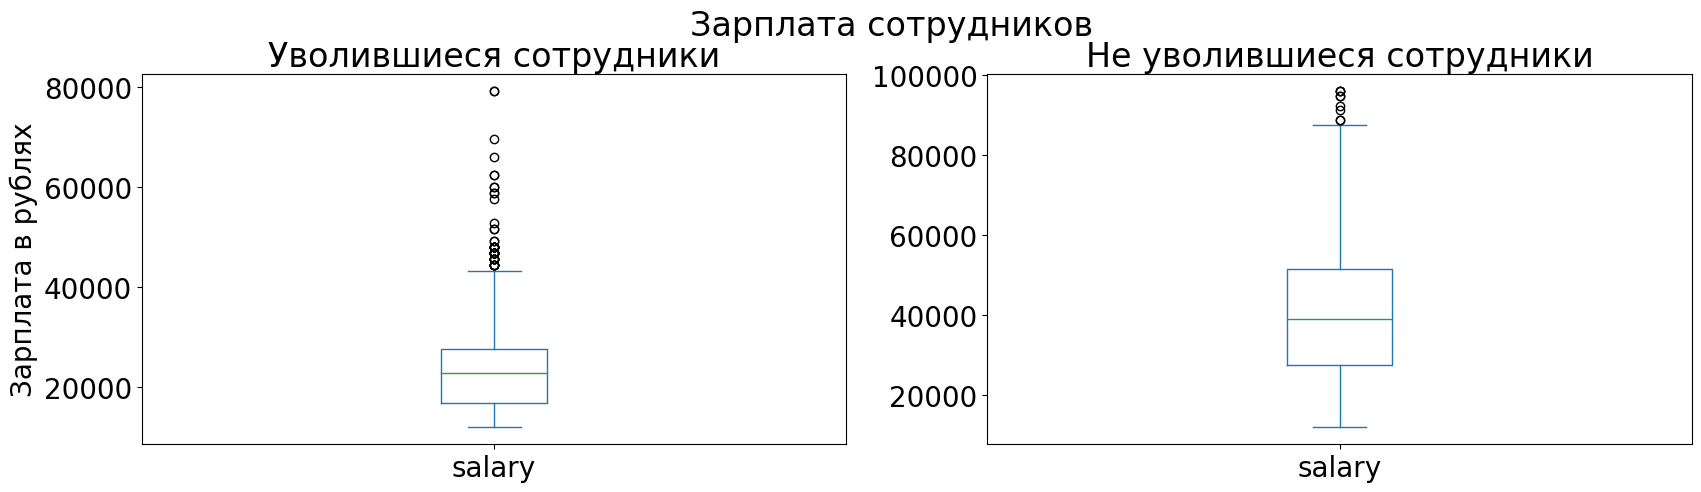

In [87]:
fig, axs = plt.subplots(nrows= 1 , ncols= 2 )
fig.set_size_inches(20, 5)

quit_yes['salary'].plot(kind='box',ax=axs[0])
axs[0].set_title('Уволившиеся сотрудники')
axs[0].set_ylabel('Зарплата в рублях')

quit_no['salary'].plot(kind='box',ax=axs[1])
axs[1].set_title('Не уволившиеся сотрудники')

fig.suptitle('Зарплата сотрудников')
plt.subplots_adjust(top= 0.85 )
plt.show()

In [88]:
print('Медиана зарплаты уволившихся сотрудников:', np.median(quit_yes['salary']))
print('Медиана зарплаты не уволившихся сотрудников:', np.median(quit_no['salary']))

Медиана зарплаты уволившихся сотрудников: 22800.0
Медиана зарплаты не уволившихся сотрудников: 39000.0


В среднем зарплата уволившихся сотрудников на 10000 рублей меньше, чем у оставшихся.

#### Quit

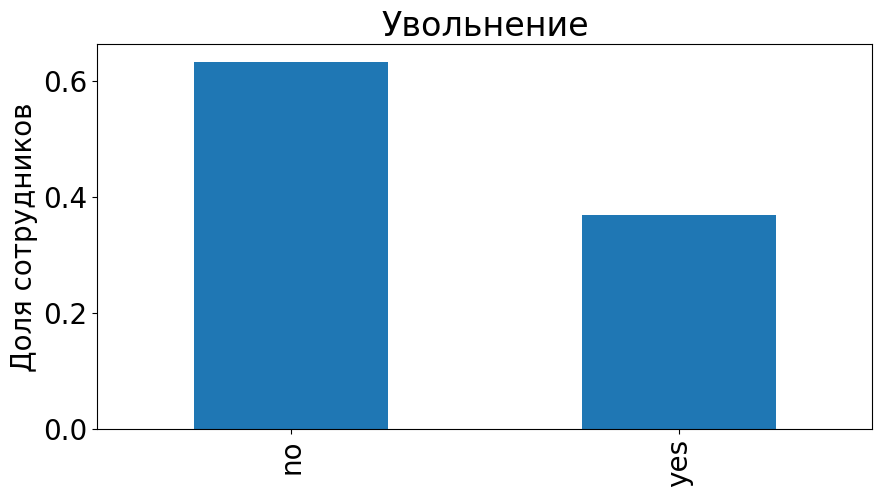

In [89]:
Xy_train2['quit'].value_counts(normalize=True).plot(kind='bar',figsize = (10,5))
plt.title('Увольнение')
plt.ylabel('Доля сотрудников')
plt.show()

В данных присутствует дисбаланс классов. Уволившиеся сотрудники составляют примерно треть от всего количества.

#### Вывод 

Для этих данных так же справедливы выводы, сделанные после исследовательского анализа для первой задачи. 

Стоит отметить, что в данных присутствует дисбаланс классов: уволившиеся сотрудники составляют примерно четверть от всего количества.

На данном этапе мы можем составить портрет «уволившегося сотрудника»:
1. Скорее всего он будет работать в отделе продаж.
2. С большей вероятностью он будет иметь уровень junior.
3. Уровень его загруженности будет низким или средним
4. Скорее всего он будет работать с компании меньше 3 лет.
5. Вероятнее он будет получать от руководителя оценку 3.
6. В среднем зарплата уволившихся сотрудников на 10000 рублей меньше, чем у оставшихся.

На следующем шаге добавим новый признак и проанализируем, как целевой признак от него зависит, а также проведем корреляционный анализ всех признаков.

### Добавление нового входного признака

#### Добавление признака

Добавим признак `job_satisfaction_rate` в датасеты, предсказав его с помощью модели из первой задачи.

In [90]:
X_train2 = Xy_train2.drop('quit',axis=1)

In [91]:
train_pred = randomized_search.predict(X_train2)
Xy_train2['job_satisfaction_rate_pred'] = train_pred
Xy_train2.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate_pred
id,,,,,,,,,,
976652,hr,junior,medium,1,no,no,1,22800,yes,0.182500
100969,marketing,junior,medium,2,no,no,3,26400,yes,0.317500
734768,purchasing,middle,medium,5,no,no,2,38400,no,0.326667
537945,purchasing,junior,low,1,no,no,5,15600,no,0.626667
339697,technology,junior,medium,1,no,no,5,32400,no,0.671250


In [92]:
test_pred = randomized_search.predict(X_test2)
X_test2['job_satisfaction_rate_pred'] = test_pred
X_test2.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate_pred
id,,,,,,,,,
100298,hr,junior,low,2,no,no,4,19200,0.831667
100480,marketing,junior,low,4,no,no,4,16800,0.850000
100503,purchasing,middle,high,5,no,no,4,55200,0.790000
100610,sales,middle,medium,5,no,no,4,43200,0.810000
100692,sales,middle,high,6,no,no,4,48000,0.712500


#### Корреляционный анализ

Построим матрицы корреляции для признаков в тренировочной и тестовой выборках.

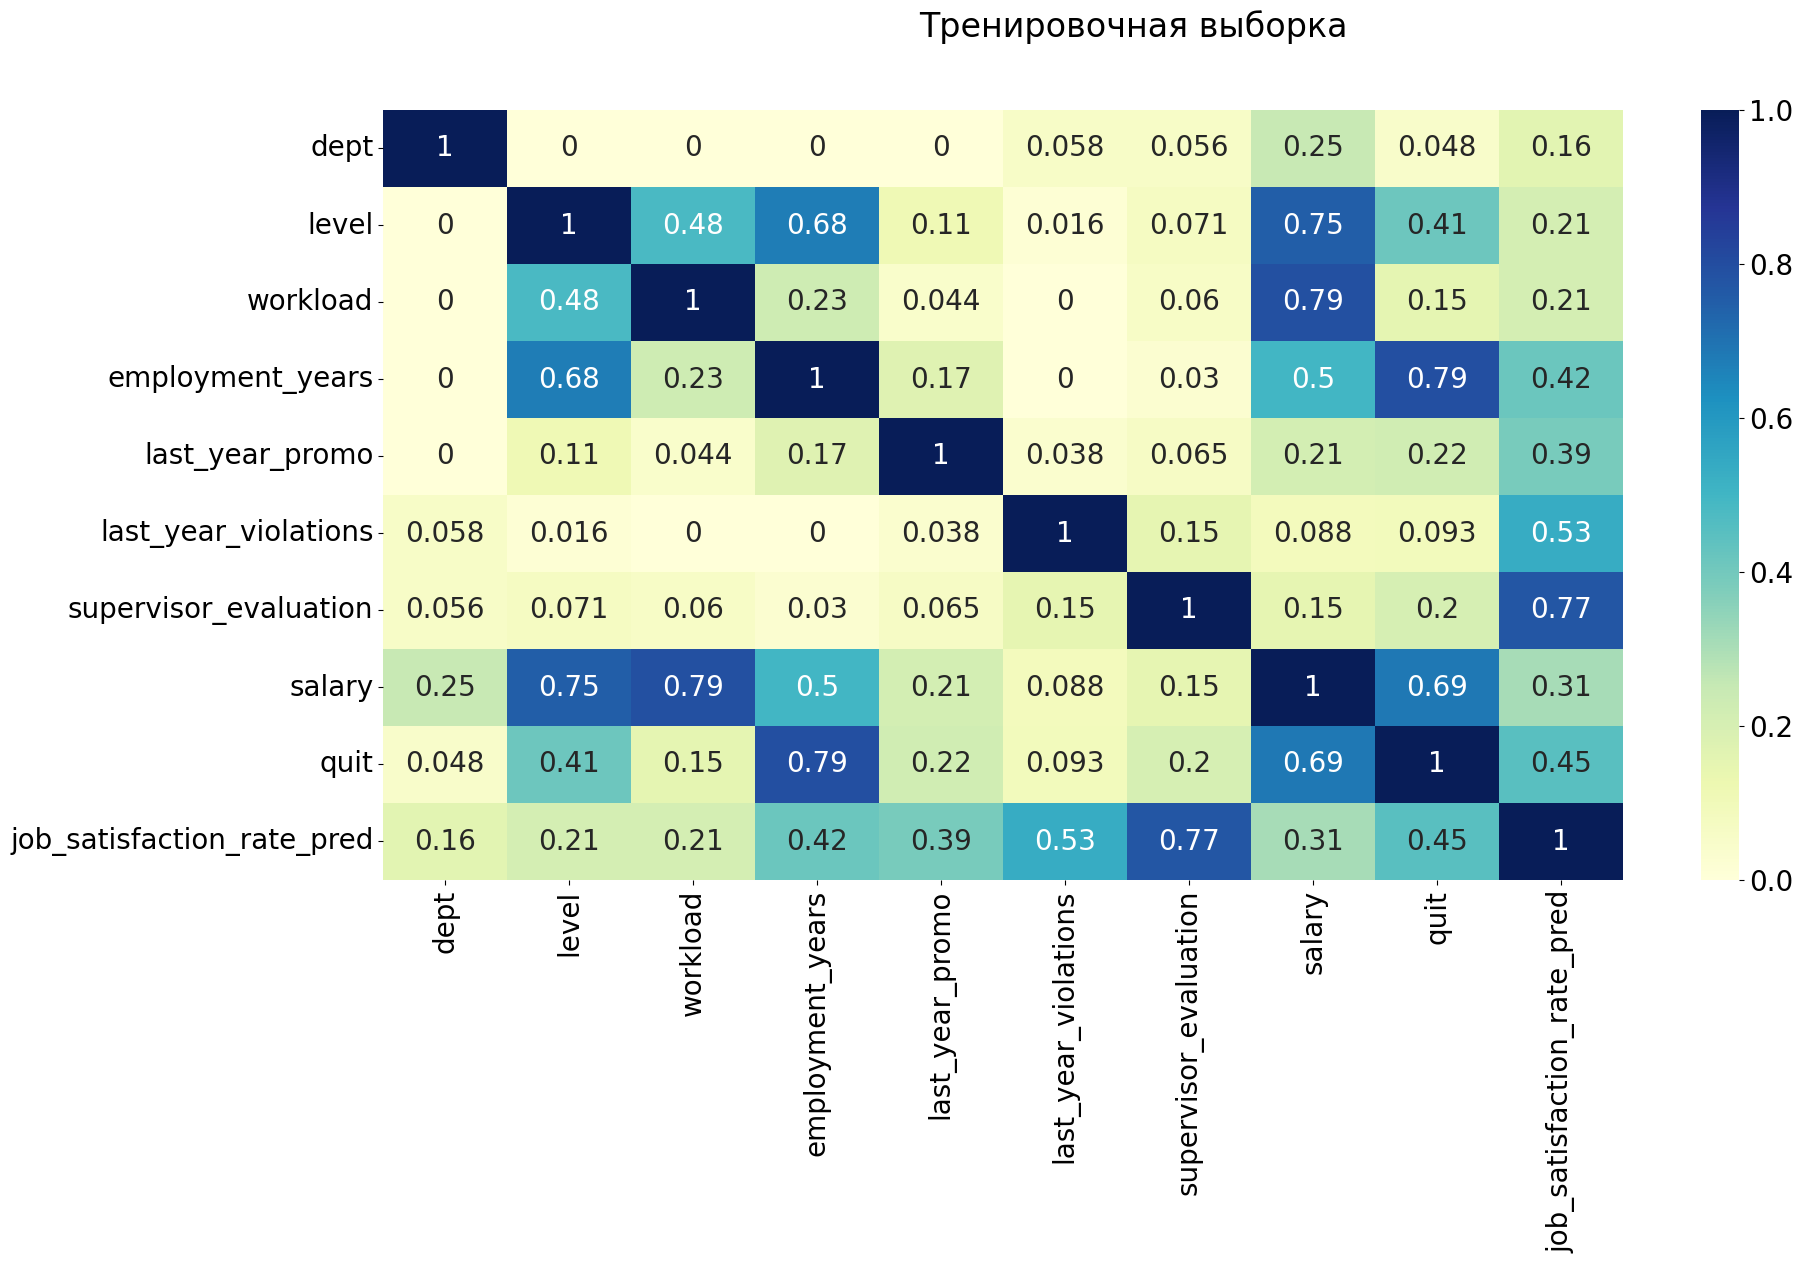

In [93]:
fig, ax = plt.subplots(figsize=(20, 10))
fig.suptitle('Тренировочная выборка')
sns.heatmap(Xy_train2.phik_matrix(interval_cols=['salary','job_satisfaction_rate_pred']), annot=True, cmap='YlGnBu');

In [94]:
Xy_test2 = X_test2.merge(y_test2, right_index=True, left_index=True)
Xy_test2.shape

(2000, 10)

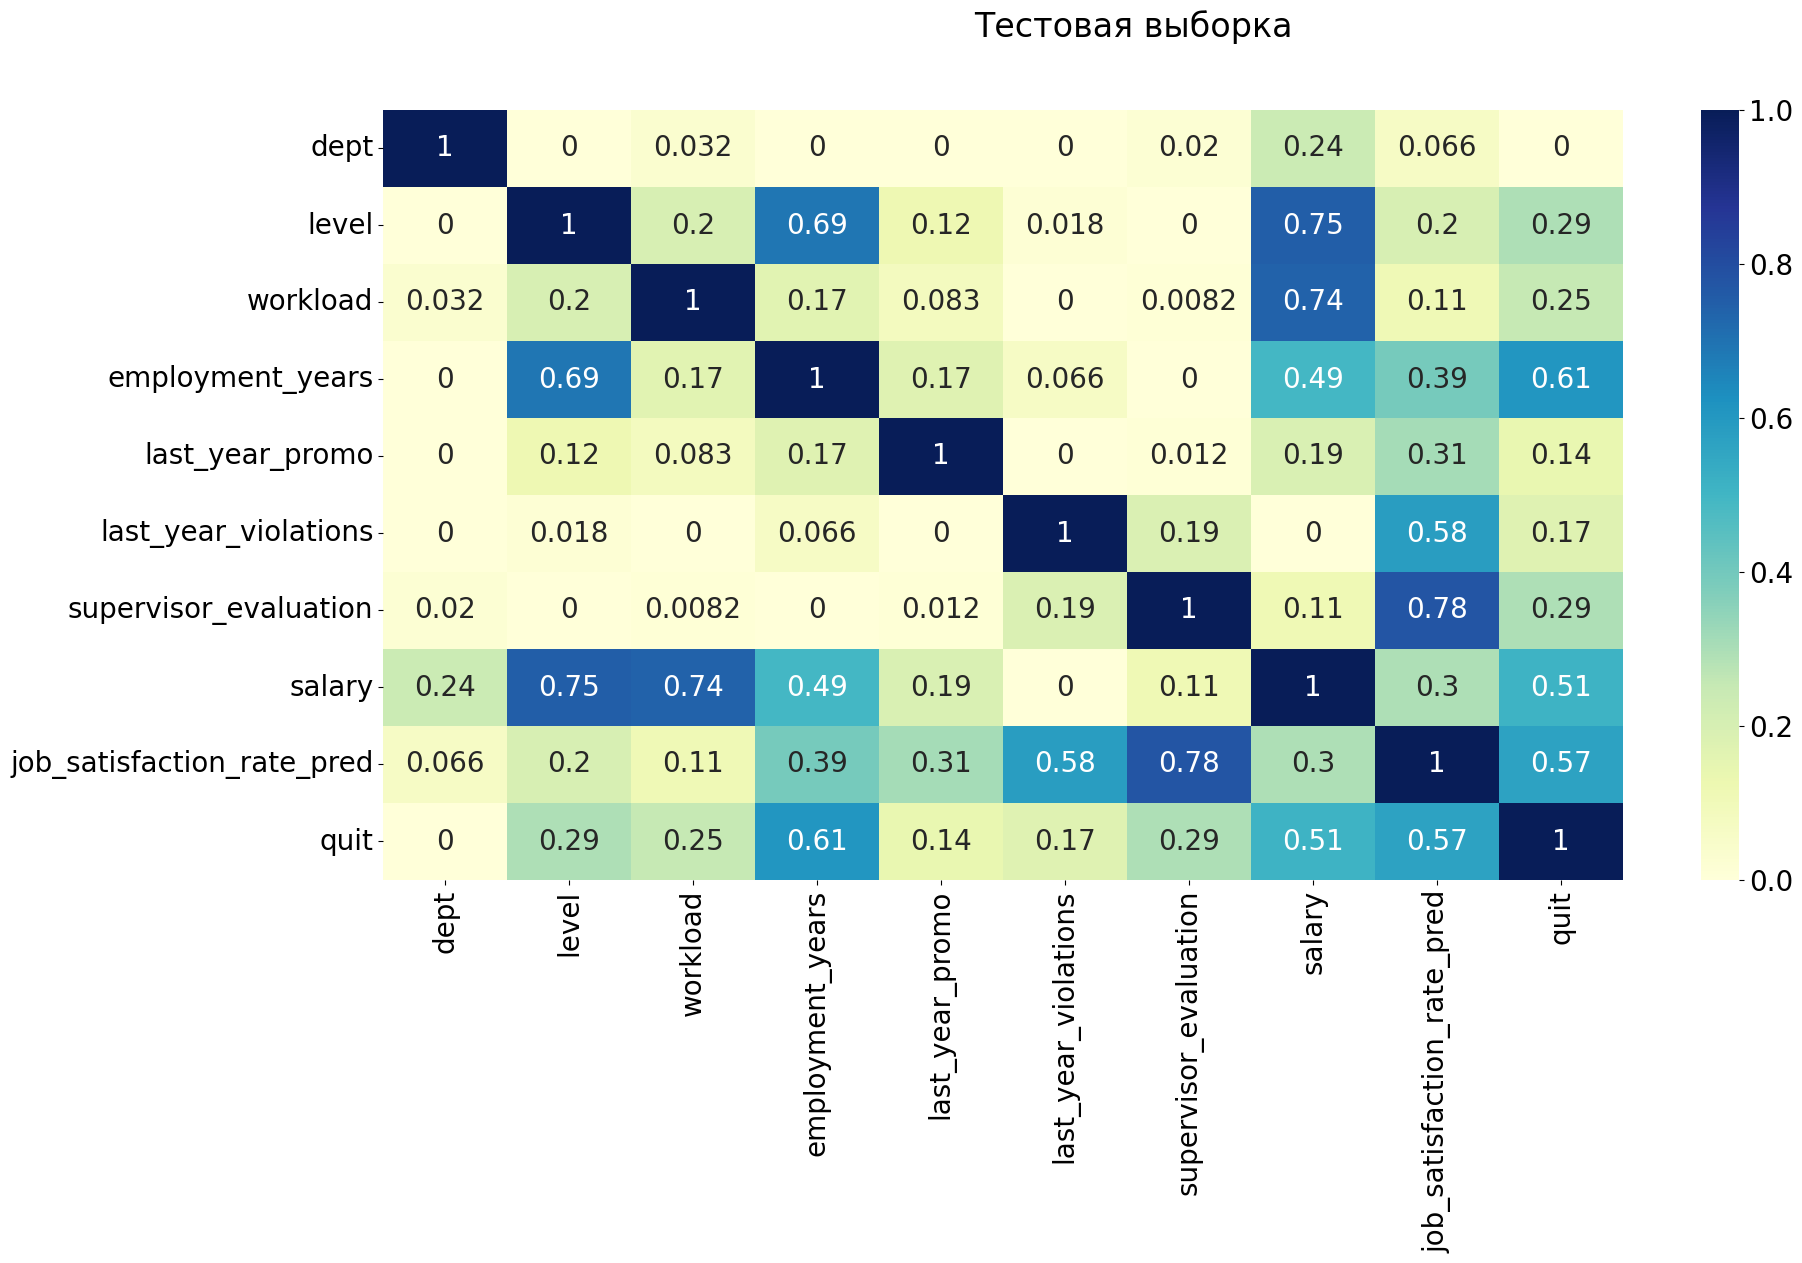

In [95]:
fig, ax = plt.subplots(figsize=(20, 10))
fig.suptitle('Тестовая выборка')
sns.heatmap(Xy_test2.phik_matrix(interval_cols=['salary','job_satisfaction_rate_pred']), annot=True, cmap='YlGnBu');

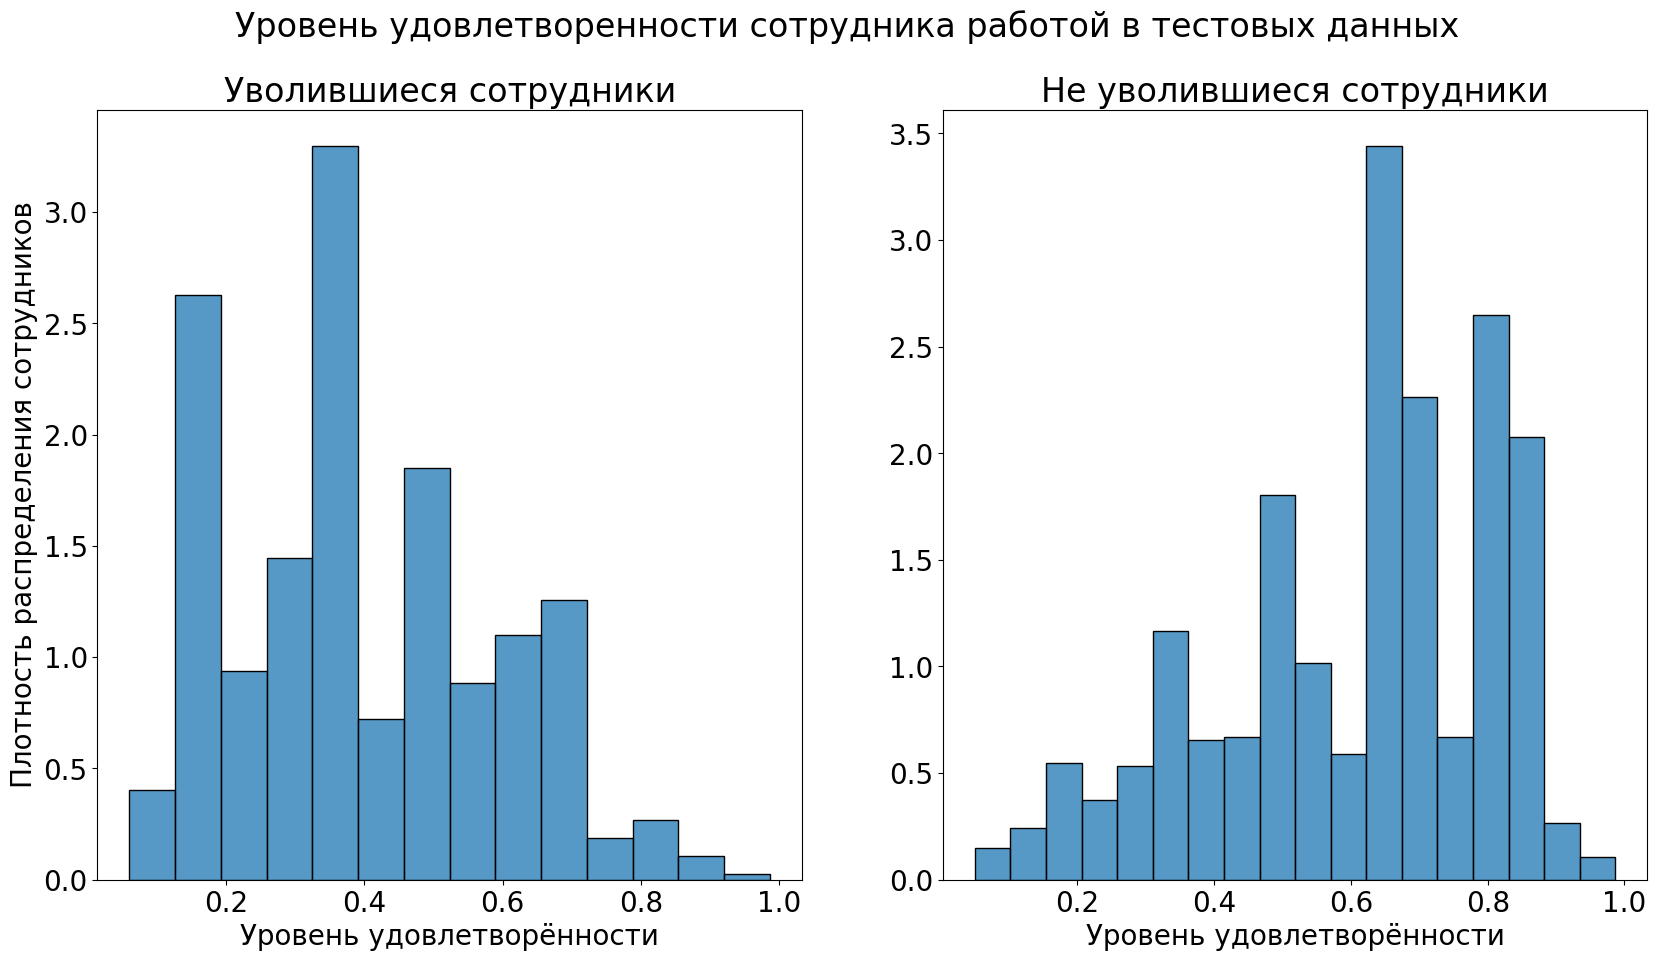

In [96]:
fig, axs = plt.subplots(nrows= 1 , ncols= 2 )
fig.set_size_inches(20, 10)
plt.rcParams['font.size'] = '20'

sns.histplot(Xy_test2[Xy_test2['quit']=='yes']['job_satisfaction_rate_pred'],stat='density', common_norm=False,ax=axs[0])
axs[0].set_ylabel('Плотность распределения сотрудников')
axs[0].set_xlabel('Уровень удовлетворённости')
axs[0].set_title('Уволившиеся сотрудники')

sns.histplot(Xy_test2[Xy_test2['quit']=='no']['job_satisfaction_rate_pred'],stat='density', common_norm=False,ax=axs[1])
axs[1].set_ylabel('')
axs[1].set_xlabel('Уровень удовлетворённости')
axs[1].set_title('Не уволившиеся сотрудники')

fig.suptitle('Уровень удовлетворенности сотрудника работой в тестовых данных')
plt.show()

#### Вывод
Целевой признак имеет положительную корреляцию с признаками `supervisor_evaluation`, `salary` и `job_satisfaction_rate_pred`. Посмотрев на распределения последнего признака и коэффициент корреляции, можно сказать, что он влияет на то, уволится ли сотрудник. Уровень удовлетворенности работой у уволившихся сотрудников в основном от 0.2 до 0.6, в то время как у не уволившихся от 0.6 до 0.9.

Мультиколлинеарности в данных нет.

### Подготовка данных

Подготовка данных такая же как и в первой задаче.

In [97]:
ohe_col = ['dept','last_year_promo','last_year_violations']
ord_col = ['level','workload']
num_col = ['employment_years','supervisor_evaluation','salary','job_satisfaction_rate_pred']

In [98]:
ohe_pip = Pipeline([
    ( 'simpleImputer_ohe_nan', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent') 
    ),
    ( 'simpleImputer_ohe_blank',
             SimpleImputer(missing_values=' ', strategy='most_frequent')
    ),
    ( 'ohe', 
            OneHotEncoder(drop='first', handle_unknown='error', sparse=False)
    )
])

In [99]:
ord_pip = Pipeline([
    ('simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
    ('ord',  
            OrdinalEncoder(
                categories=[
                    ['junior','middle','senior'], 
                    ['low','medium','high']
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
    ('simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
])

In [100]:
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pip, ohe_col),
     ('ord', ord_pip, ord_col),
     ('num', StandardScaler(), num_col)
    ], 
    remainder='passthrough'
)

Разделим `Xy_train2` на входные признаки и целевой. Затем закодируем значения целевого признака.

In [101]:
X_train2 = Xy_train2.drop('quit', axis=1)
y_train2 = Xy_train2['quit']

In [102]:
le = LabelEncoder()
y_train2 = le.fit_transform(y_train2)
y_test2 = le.transform(y_test2)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


In [103]:
le.classes_

array(['no', 'yes'], dtype=object)

### Обучение модели

In [104]:
pipe_final2 = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

In [105]:
param_grid2 = [
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2,11),
        'models__min_samples_split': range(2,11),
        'models__min_samples_leaf': range(1,11),
        'models__max_features': range(2,7) 
    },
    
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2,10)
    },

    {
        'models': [SVC(probability=True, random_state=RANDOM_STATE)],
        'models__C': range(1,5),
        'models__kernel': ['linear', 'rbf', 'sigmoid','poly']
    }
]

In [106]:
randomized_search2 = RandomizedSearchCV(
    pipe_final2, 
    param_grid2, 
    cv=5,
    scoring='roc_auc', 
    n_jobs=-1
)

randomized_search2.fit(X_train2, y_train2)

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe_nan',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('simpleImputer_ohe_blank',
                                                                                                SimpleImputer(missing_values=' ',
                                                                                                              strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              sparse=False))]),
                                                                               ['...
                                         'models__max_depth': range(2, 11),
                                         'models__max_features': range(2, 7),
                                         'models__min_samples_leaf': range(1, 11),
                                         'models__min_samples_split': range(2, 11)},
                                        {'models': [KNeighborsClassifier()],
                                         'models__n_neighbors': range(2, 10)},
                                        {'models': [SVC(probability=True,
                                                        random_state=42)],
                                         'models__C': range(1, 5),
                                         'models__kernel': ['linear', 'rbf',
                                                            'sigmoid',
                                                            'poly']}],
                   scoring='roc_auc')

In [107]:
print('Метрика roc_auc для лучшей модели:\n', randomized_search2.best_score_)
print('\nЛучшая модель и её параметры:\n\n', randomized_search2.best_estimator_) 

Метрика roc_auc для лучшей модели:
 0.9277024456986975

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe_nan',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('simpleImputer_ohe_blank',
                                                                   SimpleImputer(missing_values=' ',
                                                                                 strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=

In [108]:
y_pred2 = randomized_search2.predict_proba(X_test2)[:,1]

In [109]:
print('Значение метрики roc_auc на тестовых данных:',roc_auc_score(y_test2 ,y_pred2))

Значение метрики roc_auc на тестовых данных: 0.9018470090282305


Критерий успеха: ROC-AUC ≥0.91 на тестовой выборке. Мы достигли этого с помощью обработки данных и подбора гиперпараметров. Проанализируем важность признаков.

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


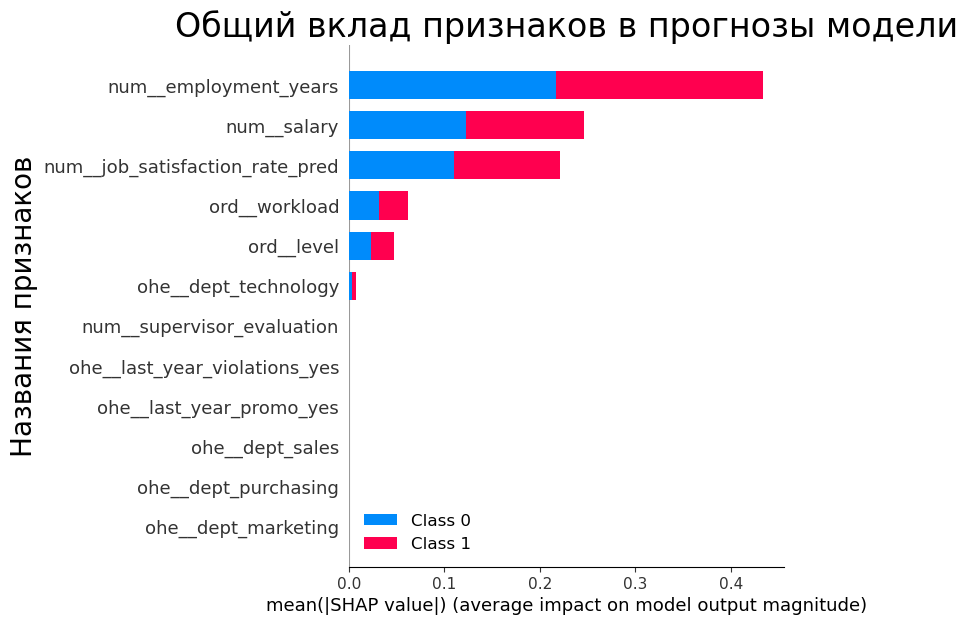

In [110]:
x_train2 = pipe_final2.named_steps['preprocessor'].fit_transform(X_train2)
x_test2 = pipe_final2.named_steps['preprocessor'].transform(X_test2)

explainer2 = shap.TreeExplainer(randomized_search2.best_estimator_.named_steps['models'])

feature_names = pipe_final2.named_steps['preprocessor'].get_feature_names_out()
x_test2 = pd.DataFrame(x_test2, columns=feature_names)

shap_values = explainer2.shap_values(x_test2)

shap.summary_plot(shap_values, x_test2, show=False)  
plt.title('Общий вклад признаков в прогнозы модели')
plt.ylabel('Названия признаков')
plt.show()

Больше всего на результат работы модели влияет три признака: `employment_years`, `supervisor_evaluation` и `level`.

### Вывод

Мы выполнили задачу: построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

В ходе исследования мы составили портрет "уволившегося сотрудника":
- Скорее всего он будет работать в отделе продаж.
- С большей вероятностью он будет иметь уровень junior.
- Уровень его загруженности будет низким или средним
- Скорее всего он будет работать с компании меньше 3 лет.
- Вероятнее он будет получать от руководителя оценку 3.
- В среднем зарплата уволившихся сотрудников на 10000 рублей меньше, чем у оставшихся.

Мы искали лучшую модель среди трех: DecisionTreeClassifier, KNeighborsClassifier, SVC. "Победила" модель дерева решений. Значение метрики roc_auc на тестовых данных меньше 0.91. Больше всего на результат работы модели влияют признаки `employment_years`, `supervisor_evaluation` и `level`.

## Общий вывод

Были поставлены задачи построить модели, одна из которых сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика, а другая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

Были предоставлены данные об отделе, уровене занимаемой должности, уровене загруженности сотрудника, длительности работы в компании, повышении за последний год, показывает, нарушении сотрудника трудового договора, оценке качества работы сотрудника руководителем, ежемесячной зарплате сотрудника.

Проведя исследовательский и корреляционный анализ, мы выяснили, что:
1. Больше всего сотрудников в отделе продаж.
2. Больше всего в компании джуниор сотрудников и незначительно меньше мидл сотрудников.
3. В основном у сотрудников средний уровень загруженности.
4. Большинство сотрудников работают в компании 1-2 года.
5. Чаще всего сотридники получают от руководителя оценку 3 или 4.
6. За последний год повышение получило приммерно 3% от всех сотрудников.
7. За последний год трудовой договор нарушали примерно 14 процентов сотрудников.
8. Зарплата большинства сотрудников от 10000 до 40000 рублей. Сотрудники, чья зарплата больше 70 тысяч рублей, имеют уровень sinior.
9. Количество сотрудников, недовольных работой, почти равно количеству сотрудников, довольных работой.
10. Уволившиеся сотрудники составляют примерно треть от всего количества.
11. Уровень должности имеет положительную корреляцию с зарплатой и стажем работы в компании и уровень загруженности положительно коррелирует с зарплатой. Также сильно коррелирует целевой признак с оценкой руководителя.
12. Целевой признак `quit` имеет положительную корреляцию с признаками `supervisor_evaluation`(0.66), `salary`(0.51) и `job_satisfaction_rate_pred`(0.52).
13. Уровень удовлетворенности работой у уволившихся сотрудников в основном от 0.2 до 0.6, в то время как у не уволившихся от 0.6 до 0.9.

Также мы составили портрет "уволившегося сотрудника":

    Скорее всего он будет работать в отделе продаж, будет иметь уровень junior, уровень его загруженности будет низким или средним, будет работать с компании меньше 3 лет, будет получать от руководителя оценку 3. И стоит отметить, что в среднем зарплата уволившихся сотрудников на 10000 рублей меньше, чем у оставшихся.
    
Мы подготовили данные и подобрали модели. 

Для первой и второй задач "победила" модель дерева решений. Это достаточно гибкая и неприхотливая модель, подбор гиперпараметров позволил улучшить ее результат. Для первой задачи метрика SMAPE меньше 15, для второй метрика roc_auc больше 0.91.

Анализ важности признаков показал:

сотрудник будет вероятнее удовлетворен работой если:
1. Высокая оценка руководителя
2. Большой стаж работы в компании
3. Высокая зарплата

на увольнение сотрудников больше всего влияет:
1. Стаж работы в компании
2. Оценка руководителя
3. Уровень занимаемой должности

По сделанным выводам можно сказать, что уходящие сотрудники не заинтересованы в работе, у них мало опыта и они ищут компании с хорошими условиями. Для их удержания можно поднять зарплаты и увеличить загруженность. Можно нанимать более профессиональных специалистов уровня middle и выше. Они вероятнее останутся в компании на больший срок. Молодых работников важно заинтересовать, можно повысить комфортность в офисах и помогать осваиваться в компании новым сотрудника.